In [6]:

import numpy as np
import pandas as pd
import json
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


json file names and their threshold list:

results 1:[25, 50, 75, 90, 95, 99]

results 2: [10, 25, 40, 50, 60, 75, 90, 95]

results 3: [5, 15, 25, 35, 50, 70, 80, 90, 95]

cos = cosine simmilarity distance

l2 = L2/Euclidean distance

k_values: [5, 10, 15, 20, np.sqrt(N), (np.sqrt(N))/2, log2(N)]

In [7]:
SAVE = False
OUTPUT_FILE = "/home/users/orrbavly/GNN_project/percentiles/outputs/cos_3_all_results.csv"

In [8]:
# Load data
INPUT_JSON = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_cos_3_all_TRA.json"
data_type = 'colon'

In [9]:
def load_results(file_path):
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    return all_results

In [10]:
all_results = load_results(INPUT_JSON)

# Prepare Data

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn.preprocessing

def prepare_data(percentiles_data, labels_dict, vector_indices=None, average_vectors=False):
    data = []
    labels = []

    if average_vectors:
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = np.array(list(percentiles_dict.values()))
            avg_vector = np.mean(vectors, axis=0)
            data.append(avg_vector)
            labels.append(labels_dict[sample_name])
    else:
        max_length = max(len(np.concatenate(list(percentiles_dict.values()))) for percentiles_dict in percentiles_data.values())
        for sample_name, percentiles_dict in percentiles_data.items():
            vectors = list(percentiles_dict.values())
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_percentiles = np.concatenate(selected_vectors)
            else:
                flattened_percentiles = np.concatenate(vectors)
            padded_percentiles = np.pad(flattened_percentiles, (0, max_length - len(flattened_percentiles)), 'constant')
            data.append(padded_percentiles)
            labels.append(labels_dict[sample_name])

    data = np.array(data)
    labels = np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


In [12]:
def filter_samples(data, criteria):
    filtered_data = {key: value for key, value in data.items() if criteria not in key.lower()}
    return filtered_data


In [13]:
# Run this cell if you want to exclude sample groups from df.
# Case is case-sensitive
# all_results = filter_samples(all_results, criteria="nh")


In [14]:
labels_dict = {}
for sample_name, percentile_dict in all_results.items():
    if data_type == 'ovarian':
        if sample_name.endswith("_H"):
            labels_dict[sample_name] = 0
        elif sample_name.endswith("_OC"):
            labels_dict[sample_name] = 1
        else:
            raise Exception("Error - invalid sample type")
    elif data_type == 'colon':
        if sample_name.endswith("_low"):
            labels_dict[sample_name] = 0
        elif sample_name.endswith("_high"):
            labels_dict[sample_name] = 1
        else:
            raise Exception("Error - invalid sample type")

# ML algorithms

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_knn(X_train, X_test, y_train, y_test, neighbors=5):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("KNN Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))


    return knn, {'model': 'KNN', 'accuracy': accuracy, 'classification_report': class_report}


## Logistic Regression:

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test):
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)
    y_pred = logistic_regression.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Logistic Regression Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, logistic_regression.predict_proba(X_test)[:, 1]))


    return logistic_regression, {'model': 'Logistic Regression', 'accuracy': accuracy, 'classification_report': class_report}


## SVM

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("SVM Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    # Use `predict_proba` if available, otherwise `decision_function`
    try:
        y_score = svm.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_score = svm.decision_function(X_test)  # Use decision function as a fallback
    print("ROC-AUC:", roc_auc_score(y_test, y_score))



    return svm, {'model': 'SVM', 'accuracy': accuracy, 'classification_report': class_report}


## Decition Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Decision Tree Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1]))

    return decision_tree, {'model': 'Decision Tree', 'accuracy': accuracy, 'classification_report': class_report}


## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test):
    random_forest = RandomForestClassifier(class_weight='balanced')
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Random Forest Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

    return random_forest, {'model': 'Random Forest', 'accuracy': accuracy, 'classification_report': class_report}


## MLP

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_mlp(X_train, X_test, y_train, y_test):
    neural_network = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
    neural_network.fit(X_train, y_train)
    y_pred = neural_network.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("MLP Results")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, neural_network.predict_proba(X_test)[:, 1]))

    return neural_network, {'model': 'MLP', 'accuracy': accuracy, 'classification_report': class_report}


## XGBoost

In [22]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("XGBoost Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    return model, {'model': 'XGBoost', 'accuracy': accuracy, 'classification_report': class_report}


## Neural Network (Keras)

In [23]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def train_and_evaluate_nn(X_train, X_test, y_train, y_test):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=0)
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Get probability predictions for ROC-AUC
    y_pred_proba = model.predict(X_test)  

    print("Neural Network Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

    return model, {'model': 'Neural Network', 'accuracy': accuracy, 'classification_report': class_report}


## Grid search

### SVM

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

def train_grid_svm(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and SVM
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('svm', SVC())  # SVM classifier
    ])

    # Define the parameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'svm__gamma': [0.001, 0.01, 0.1, 1]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


### Random Forest

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


def train_grid_rf(X_train, X_test, y_train, y_test):
    # Create a pipeline with scaling and Random Forest
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('rf', RandomForestClassifier(class_weight='balanced'))  # Random Forest classifier
    ])

    # Define the parameter grid
    param_grid = {
        'rf__n_estimators': [50, 100, 200, 300],
        'rf__max_depth': [5, 10, 15, 20, 30],
        'rf__min_samples_split': [2, 5, 10, 15],
        'rf__min_samples_leaf': [1, 2, 4, 8],
        'rf__max_features': ['sqrt', 'log2'],
        'rf__bootstrap': [True, False]
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best ROC-AUC Score from Grid Search:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nRandom Forest Results with Best Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}")


### MLP

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

def train_grid_mlp(X_train, X_test, y_train, y_test):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    # Create a pipeline with scaling and MLP
    pipe = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('mlp', MLPClassifier(max_iter=1000))  # MLP classifier
    ])

    # Define the parameter grid
    param_grid = {
        'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'mlp__activation': ['tanh', 'relu'],
        'mlp__solver': ['adam', 'sgd'],
        'mlp__alpha': [0.0001, 0.001, 0.01],
        'mlp__learning_rate': ['constant', 'adaptive']
    }

    # Initialize GridSearchCV with the pipeline and parameter grid
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Predict using the best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

### Neural Network (keras)

In [27]:
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow import keras
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Function to build a neural network model with specified parameters
# def build_model(num_layers=2, units=32, optimizer='adam'):
#     model = keras.Sequential()
#     model.add(keras.layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    
#     # Add additional hidden layers based on num_layers
#     for _ in range(num_layers - 1):
#         model.add(keras.layers.Dense(units, activation='relu'))
    
#     # Output layer
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#     # Compile model
#     model.compile(optimizer=optimizer,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# # Wrapper for the model
# model = KerasClassifier(build_fn=build_model, verbose=0)

# # Define the parameter grid
# param_grid = {
#     'num_layers': [1, 2, 3],  # Number of hidden layers
#     'units': [16, 32, 64],    # Number of units in each layer
#     'batch_size': [16, 32],   # Batch size
#     'epochs': [20, 50],       # Number of epochs
#     'optimizer': ['adam', 'rmsprop']  # Optimizer type
# }

# # Initialize GridSearchCV with the Keras model and parameter grid
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Cross-Validation Score:", grid_search.best_score_)

# # Evaluate the best model on the test set
# best_model = grid_search.best_estimator_
# y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# # Print the evaluation metrics
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred)

# print("Neural Network Results on Test Set:")
# print(f"Accuracy: {accuracy}")
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

### XGBoost

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import xgboost as xgb

def train_grid_xgboost(X_train, X_test, y_train, y_test):
    # Define the parameter grid, including scale_pos_weight
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'scale_pos_weight': [1.5, 1.7, 1.8, 2.0]  # Adjusted based on class imbalance for colon (90/49)
    }

    # Initialize the XGBClassifier
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Initialize GridSearchCV, focusing on recall for label 1
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='balanced_accuracy', cv=5, n_jobs=-1, verbose=0)

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Recall Score from Grid Search:", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate the best model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("\nXGBoost Results with Best Parameters for Label 1 Recall:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}")

# Various K values

In [29]:
results = []  # Holds all the different k values (and their models) results.
models = []


In [30]:
def run_evaluation(X_train, X_test, y_train, y_test, k_value, results, models, save_results=True):
    model_functions = [
        ('KNN', train_and_evaluate_knn),
        ('Logistic Regression', train_and_evaluate_logistic_regression),
        ('SVM', train_and_evaluate_svm),
        ('Decision Tree', train_and_evaluate_decision_tree),
        ('Random Forest', train_and_evaluate_random_forest),
        ('MLP', train_and_evaluate_mlp),
        ('XGBoost', train_and_evaluate_xgboost), 
        ('Neural Network', train_and_evaluate_nn)
    ]

    for model_name, train_func in model_functions:
        model, result = train_func(X_train, X_test, y_train, y_test)
        if save_results:
            results.append({'k_value': k_value, **result})
            models.append({'k_value': k_value, 'model_name': model_name, 'model': model})


## all k

In [49]:
X_train, X_test, y_train, y_test = prepare_data(all_results, labels_dict)

In [50]:
print(y_train, len(y_train))
print(y_test, len(y_test))

[0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0] 111
[1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0] 28


In [51]:
from collections import Counter

# Count occurrences of 0 and 1
value_counts = Counter(labels_dict.values())

# Print the number of 0s and 1s
print(f"Number of 0s: {value_counts[0]}")
print(f"Number of 1s: {value_counts[1]}")

Number of 0s: 90
Number of 1s: 49


In [52]:
run_evaluation(X_train, X_test, y_train, y_test, k_value="all_k", results=results, models=models)

KNN Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[15  4]
 [ 7  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        19
           1       0.33      0.22      0.27         9

    accuracy                           0.61        28
   macro avg       0.51      0.51      0.50        28
weighted avg       0.57      0.61      0.58        28

ROC-AUC: 0.5292397660818713


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Logistic Regression Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[19  0]
 [ 9  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       0.00      0.00      0.00         9

    accuracy                           0.68        28
   macro avg       0.34      0.50      0.40        28
weighted avg       0.46      0.68      0.55        28

ROC-AUC: 0.5497076023391814
SVM Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[19  0]
 [ 9  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        19
           1       0.00      0.00      0.00         9

    accuracy                           0.68        28
   macro avg       0.34      0.50      0.40        28
weighted avg       0.46      0.68      0.55        28




KeyboardInterrupt



In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a pipeline with scaling and SVM
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('svm', SVC())  # SVM classifier
])

# Define the parameter grid
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'svm__C': 0.1, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
Best Score: 0.6308300395256916
Test Accuracy: 0.7142857142857143
[[20  0]
 [ 8  0]]


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a pipeline with scaling and Random Forest
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('rf', RandomForestClassifier())  # Random Forest classifier
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best Score: 0.5857707509881422
Test Accuracy: 0.4642857142857143
[[12  8]
 [ 7  1]]


In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Create a pipeline with scaling and MLP
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPClassifier(max_iter=1000))  # MLP classifier
])

# Define the parameter grid
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'sgd'}
Best Score: 0.6569169960474308
Test Accuracy: 0.6428571428571429
[[18  2]
 [ 8  0]]


## Average K

In [28]:
X_train_avg, X_test_avg, y_train_avg, y_test_avg = prepare_data(all_results, labels_dict, average_vectors=True)

In [29]:
run_evaluation(X_train_avg, X_test_avg, y_train_avg, y_test_avg, k_value="avg_k", results=results, models=models)


KNN Results
Accuracy: 0.42857142857142855
Confusion Matrix:
[[10  7]
 [ 9  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56        17
           1       0.22      0.18      0.20        11

    accuracy                           0.43        28
   macro avg       0.37      0.39      0.38        28
weighted avg       0.41      0.43      0.42        28

Logistic Regression Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[17  0]
 [11  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        17
           1       0.00      0.00      0.00        11

    accuracy                           0.61        28
   macro avg       0.30      0.50      0.38        28
weighted avg       0.37      0.61      0.46        28

SVM Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[17  0]
 [11  0]]
Classification Report:
              precision   

# Centrality 

## pagerank

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
feature_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/centrality/pagerank_top10.csv")

In [20]:
def run_feature_selection(feature_df):
    # Step 1: Create Labels (1 for 'H', 0 for 'OC')
    feature_df['label'] = feature_df['graph_name'].apply(lambda x: 1 if 'OC' in x else 0)

    # Step 2: Split data into features (X) and labels (y)
    X = feature_df.drop(columns=['graph_name', 'label'])  # Features are all columns except 'graph_name' and 'label'
    y = feature_df['label']  # Labels are 1 (H) or 0 (OC)

    # Step 3: Split the dataset into training and testing sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    run_evaluation(X_train, X_test, y_train, y_test, k_value="page_rank", results=[], models=[], save_results=False)


In [21]:
run_feature_selection(feature_df)

KNN Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[14  3]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        17
           1       0.50      0.27      0.35        11

    accuracy                           0.61        28
   macro avg       0.57      0.55      0.54        28
weighted avg       0.58      0.61      0.57        28

Logistic Regression Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[15  2]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        17
           1       0.67      0.36      0.47        11

    accuracy                           0.68        28
   macro avg       0.67      0.62      0.62        28
weighted avg       0.68      0.68      0.65        28

SVM Results
Accuracy: 0.6071428571428571
Confusion Matrix:
[[17  0]
 [11  0]]
Classification Report:
              precision    

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

MLP Results
Accuracy: 0.75
Confusion Matrix:
[[17  0]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        17
           1       1.00      0.36      0.53        11

    accuracy                           0.75        28
   macro avg       0.85      0.68      0.68        28
weighted avg       0.82      0.75      0.71        28



2024-09-29 14:37:44.924467: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-29 14:37:44.938951: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16779264 bytes.
2024-09-29 14:37:44.939017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16779264 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.



ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/dsi/orrbavly/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_3640228/2691040062.py", line 1, in <module>

  File "/tmp/ipykernel_3640228/960368646.py", line 12, in run_feature_selection

  File "/tmp/ipykernel_3640228/2767086632.py", line 14, in run_evaluation

  File "/tmp/ipykernel_3640228/2783800479.py", line 13, in train_and_evaluate_nn

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 16779264 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_5572]

# General EDA

## Analyzing Json files

In [31]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [32]:
def load_percentiles(json_path):
    """Load JSON and structure each sample as a list of lists for plotting."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    samples = []
    for sample_name, percentiles_dict in data.items():
        # Convert each dictionary to a sorted list of lists
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
        samples.append(sample_data)
    
    return samples

def plot_percentiles(samples, dataset_name, k_labels):
    """Plot the mean and standard deviation of percentiles for each k value."""
    plt.figure(figsize=(10, 6))
    
    # Assign a unique color for each k value
    colors = plt.cm.viridis(np.linspace(0, 1, len(k_labels)))
    
    for k_index, k_label in enumerate(k_labels):
        k_percentiles = []
        
        # Collect the k-th percentile data across all samples
        for sample in samples:
            if k_index < len(sample):  # Ensure we don't index out of bounds
                percentiles = sample[k_index][1:]  # Skip the first element (k value)
                k_percentiles.append(percentiles)
        
        k_percentiles = np.array(k_percentiles)
        
        # Calculate mean and standard deviation
        mean_percentiles = np.mean(k_percentiles, axis=0)
        std_percentiles = np.std(k_percentiles, axis=0)
        
        # Plot with error bars
        plt.plot(mean_percentiles, color=colors[k_index], label=f'k={k_label}')
        plt.fill_between(range(len(mean_percentiles)), 
                         mean_percentiles - std_percentiles, 
                         mean_percentiles + std_percentiles, 
                         color=colors[k_index], alpha=0.2)
    
    plt.title(f"Percentile Values for {dataset_name} Dataset")
    plt.xlabel("Percentile Index")
    plt.ylabel("Percentile Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [33]:
import seaborn as sns

def plot_grouped_histograms(samples_group_0, samples_group_1, k_labels):
    """Plot grouped histograms for each k value with normalized frequency and arranged in a grid."""
    n_k = len(k_labels)
    n_cols = 3  # Number of plots per row
    n_rows = (n_k + n_cols - 1) // n_cols  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=True)
    axs = axs.flatten()  # Flatten to easily iterate over each axis
    
    for k_index, k_label in enumerate(k_labels):
        # Collect percentiles for the current k value from each group
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group for the current k value
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Calculate x-axis limits dynamically based on the data range
        min_val = min(group_0_data.min(), group_1_data.min())
        max_val = max(group_0_data.max(), group_1_data.max())
        x_margin = 0.05 * (max_val - min_val)  # Add a margin to the limits
        
        # Plot histogram for each group with normalization
        axs[k_index].hist(group_0_data, bins=30, alpha=0.5, label='Group 0', color='blue', density=True)
        axs[k_index].hist(group_1_data, bins=30, alpha=0.5, label='Group 1', color='orange', density=True)
        axs[k_index].set_title(f'k={k_label}')
        axs[k_index].set_ylabel("Density")
        axs[k_index].set_yscale('log')
        axs[k_index].set_xlim(min_val - x_margin, max_val + x_margin)  # Set dynamic x-axis limits
        axs[k_index].legend()
    
    # Hide any unused subplots
    for i in range(k_index + 1, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_box_plots(samples_group_0, samples_group_1, k_labels):
    """Plot box plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the box plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
       # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.boxplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'], legend=False)
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def plot_violin_plots(samples_group_0, samples_group_1, k_labels):
    """Plot violin plots for each k value, separated by group."""
    fig, axs = plt.subplots(1, len(k_labels), figsize=(4 * len(k_labels), 6), sharey=True)
    
    for k_index, k_label in enumerate(k_labels):
        # Prepare data for the violin plot
        group_0_data = [sample[k_index][1:] for sample in samples_group_0]
        group_1_data = [sample[k_index][1:] for sample in samples_group_1]
        
        # Flatten the data for each group
        group_0_data = np.concatenate(group_0_data)
        group_1_data = np.concatenate(group_1_data)
        
        # Create a DataFrame for easier plotting with seaborn
        data = {
            'Percentile Value': np.concatenate([group_0_data, group_1_data]),
            'Group': ['Group 0'] * len(group_0_data) + ['Group 1'] * len(group_1_data)
        }
        sns.violinplot(data=data, x='Group', y='Percentile Value', hue='Group', ax=axs[k_index], palette=['blue', 'orange'])
        axs[k_index].set_title(f'k={k_label}')
    
    plt.tight_layout()
    plt.show()


def run_plots(samples_group_0, samples_group_1, k_labels):
    plot_grouped_histograms(samples_group_0, samples_group_1, k_labels)
    plot_box_plots(samples_group_0, samples_group_1, k_labels)
    plot_violin_plots(samples_group_0, samples_group_1, k_labels)


def load_json_groups(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    for sample_name, percentiles_dict in data.items():
        if 'H' in sample_name or 'low' in sample_name:
            # Convert each dictionary to a sorted list of lists
            sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
            group_0.append(sample_data)
        elif 'OC' in sample_name or 'high' in sample_name:
            # Convert each dictionary to a sorted list of lists
            sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]
            group_1.append(sample_data)
    
    return group_0, group_1

In [34]:
# Load the JSON files
ovarian_data = load_percentiles("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
colon_data = load_percentiles("/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_cos_3_all_TRA.json")

# Define k values (assuming they are the same for both datasets)
k_values = [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']  # Custom labels as specified


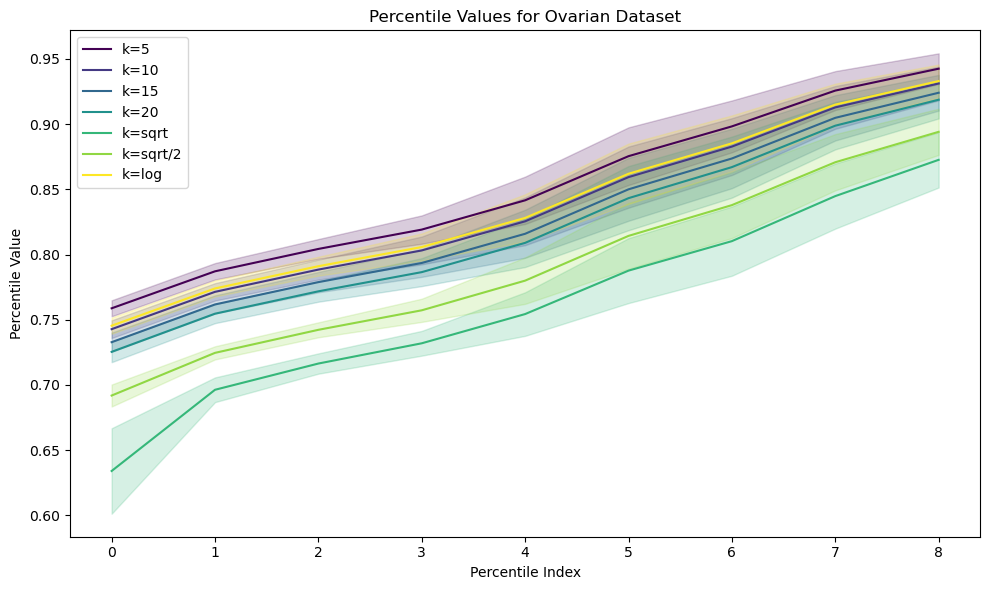

In [35]:
# Plot percentiles for ovarian dataset
plot_percentiles(ovarian_data, "Ovarian", k_values)

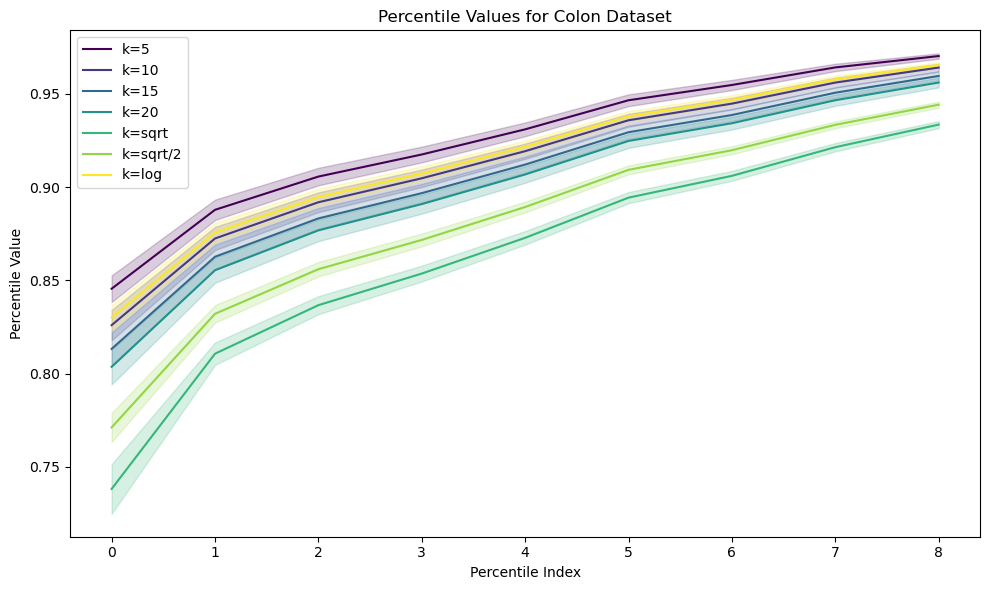

In [36]:
# Plot percentiles for colon dataset
plot_percentiles(colon_data, "Colon", k_values)

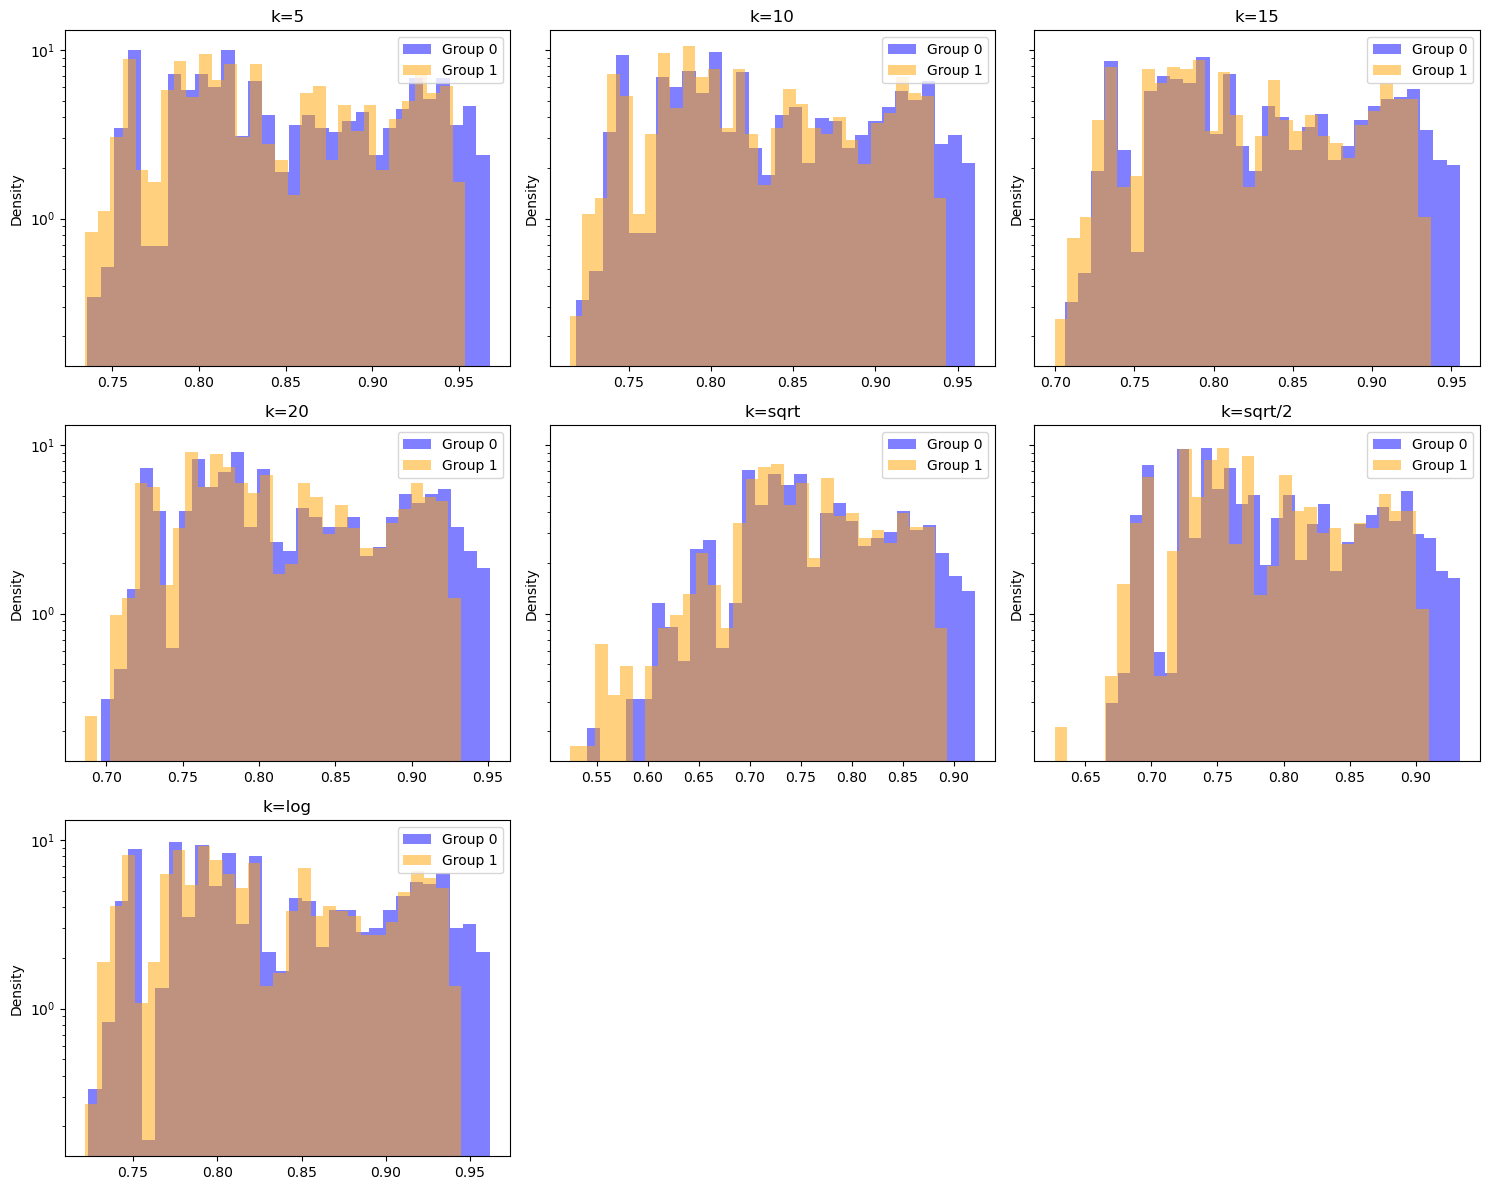

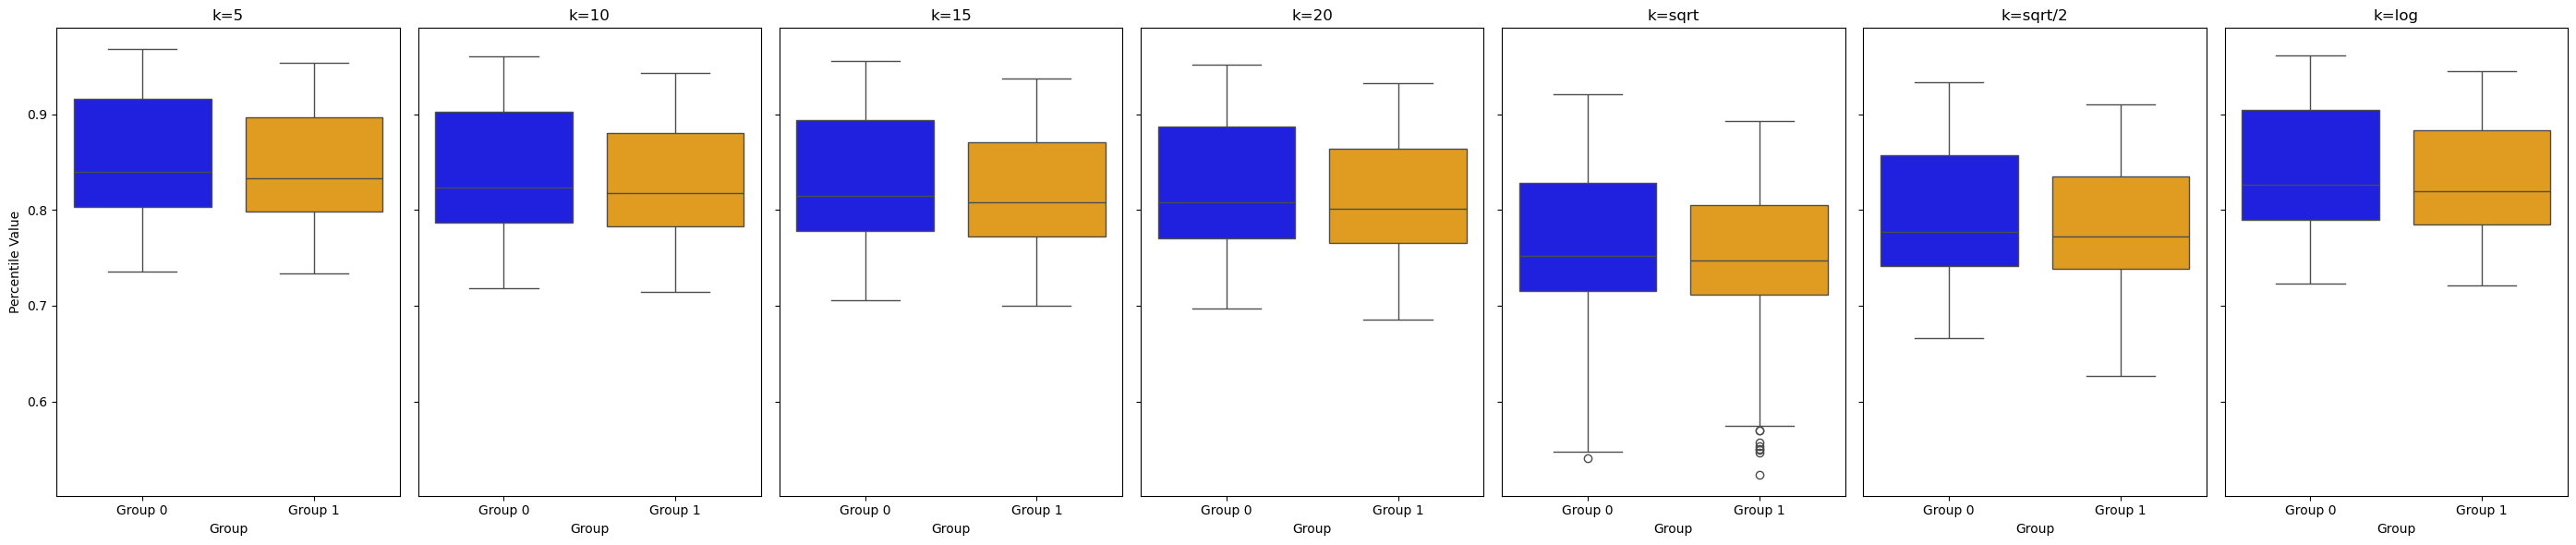

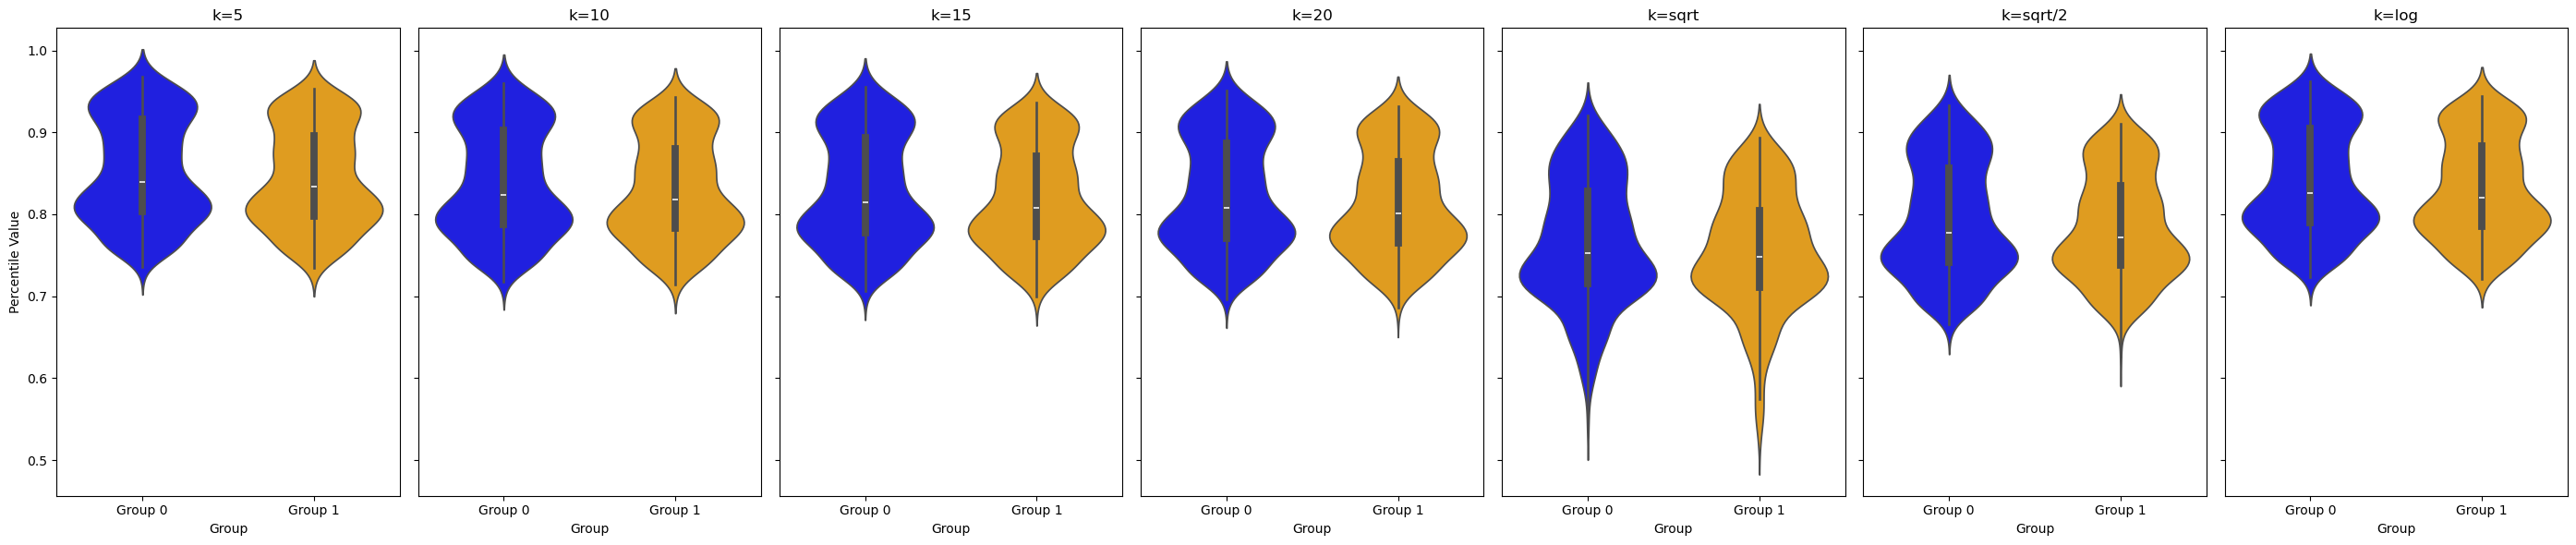

In [37]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json")
run_plots(group0, group1, k_values)

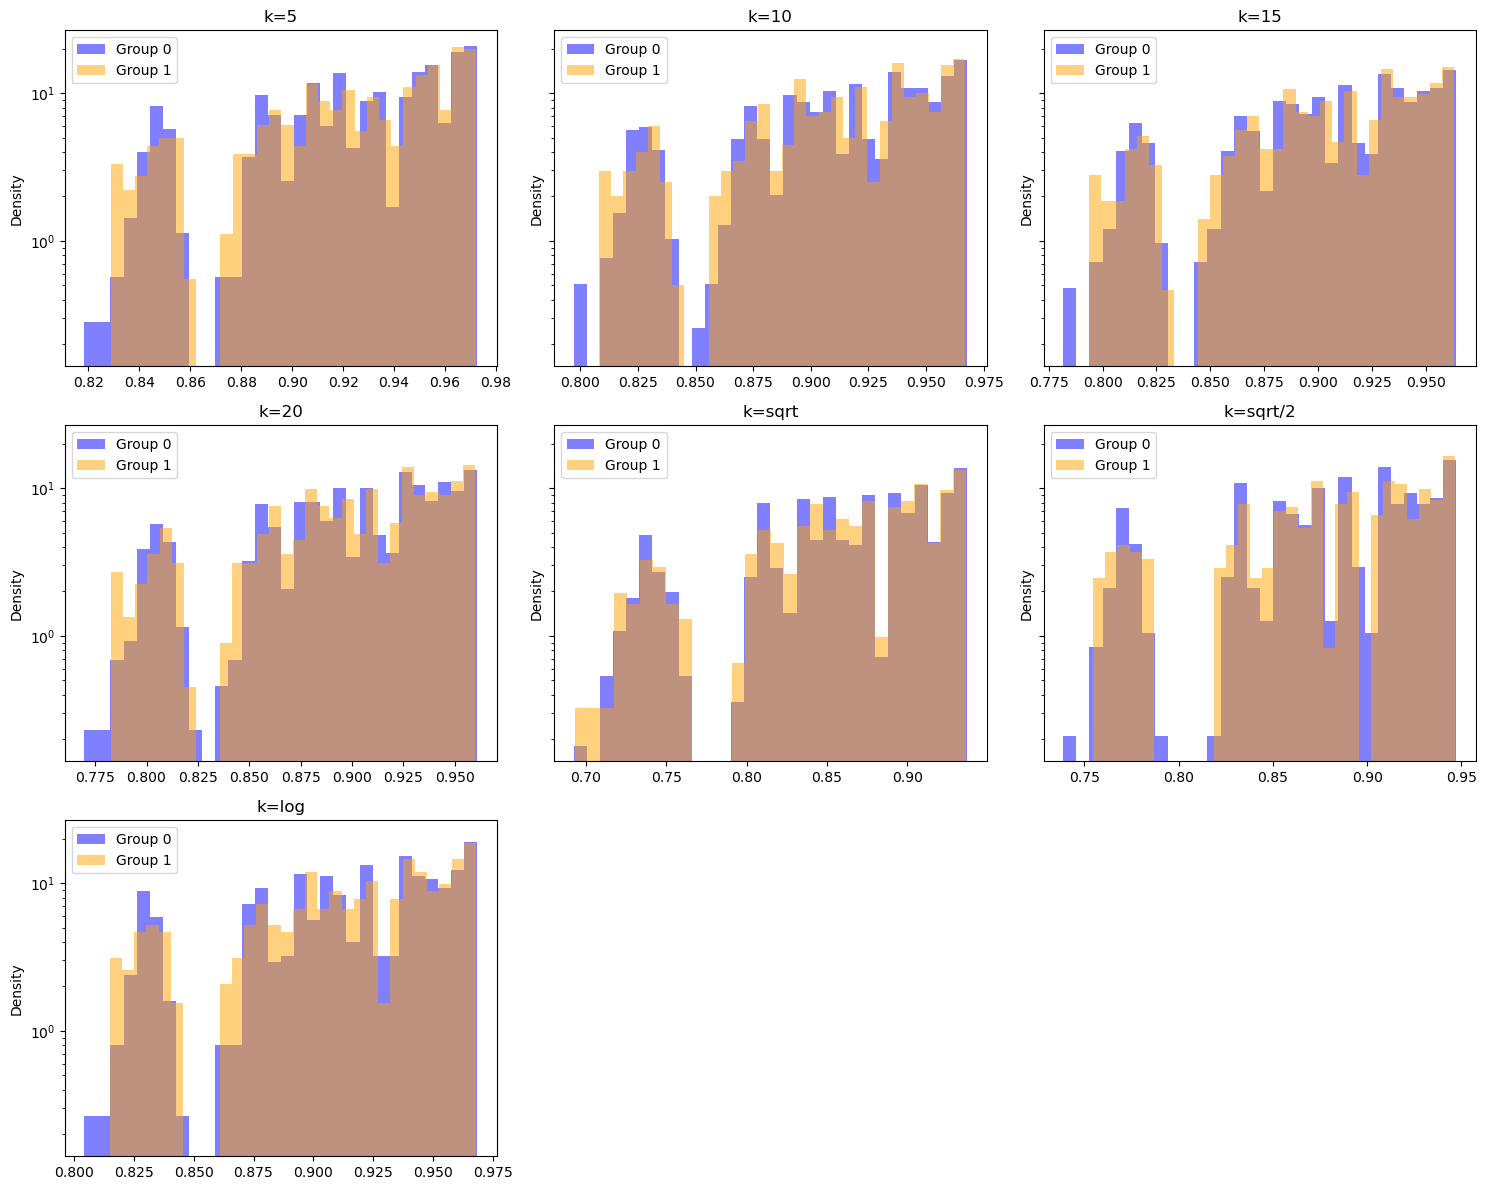

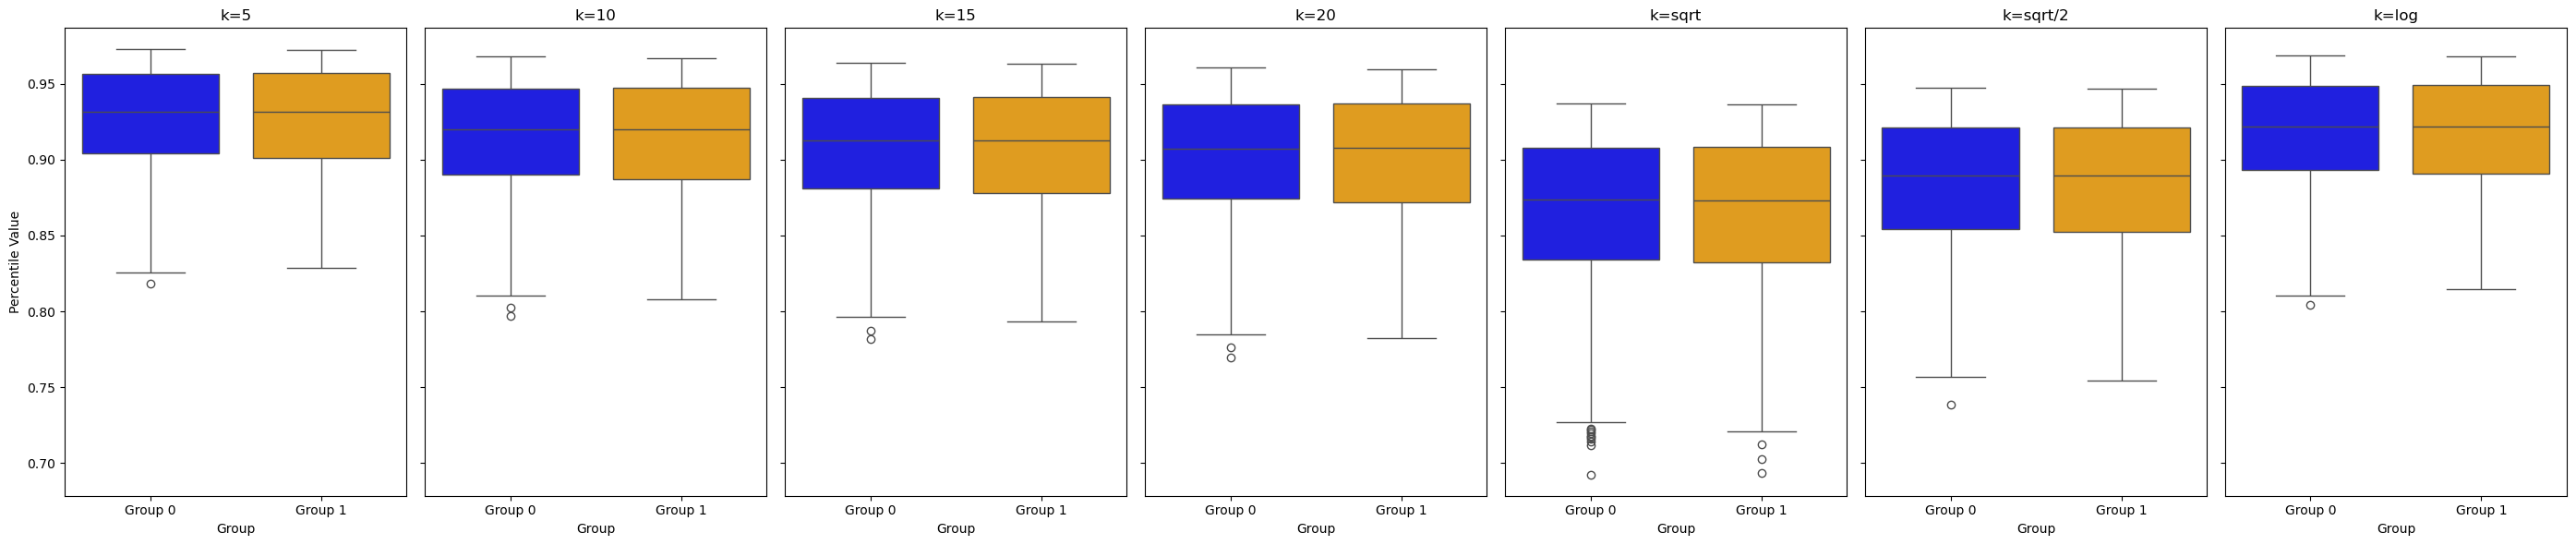

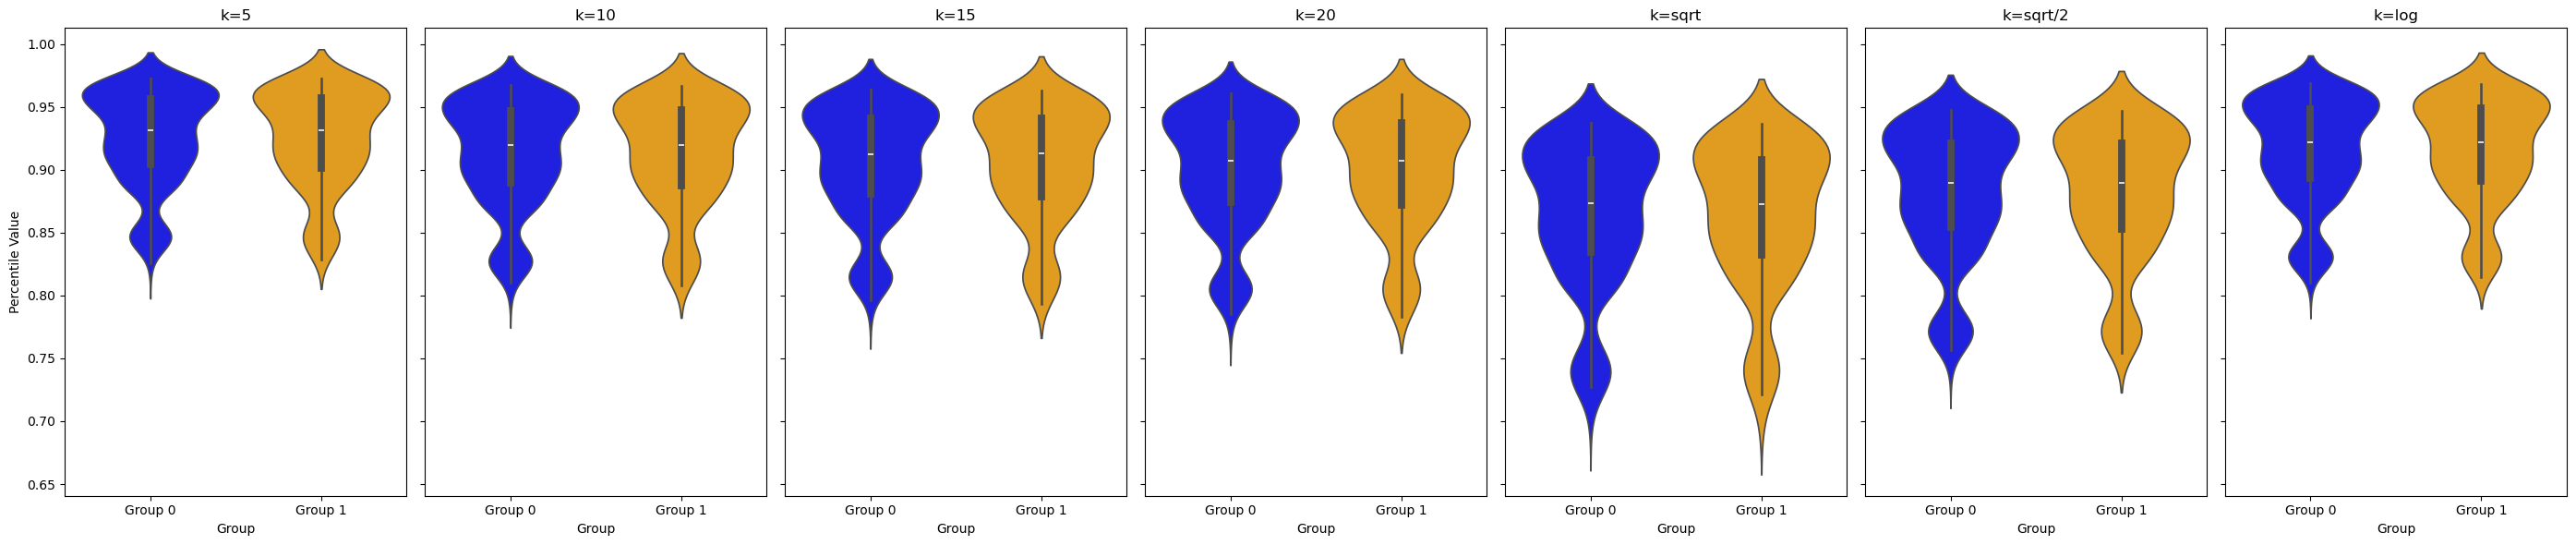

In [39]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_cos_3_all_TRA.json")
run_plots(group0, group1, k_values)

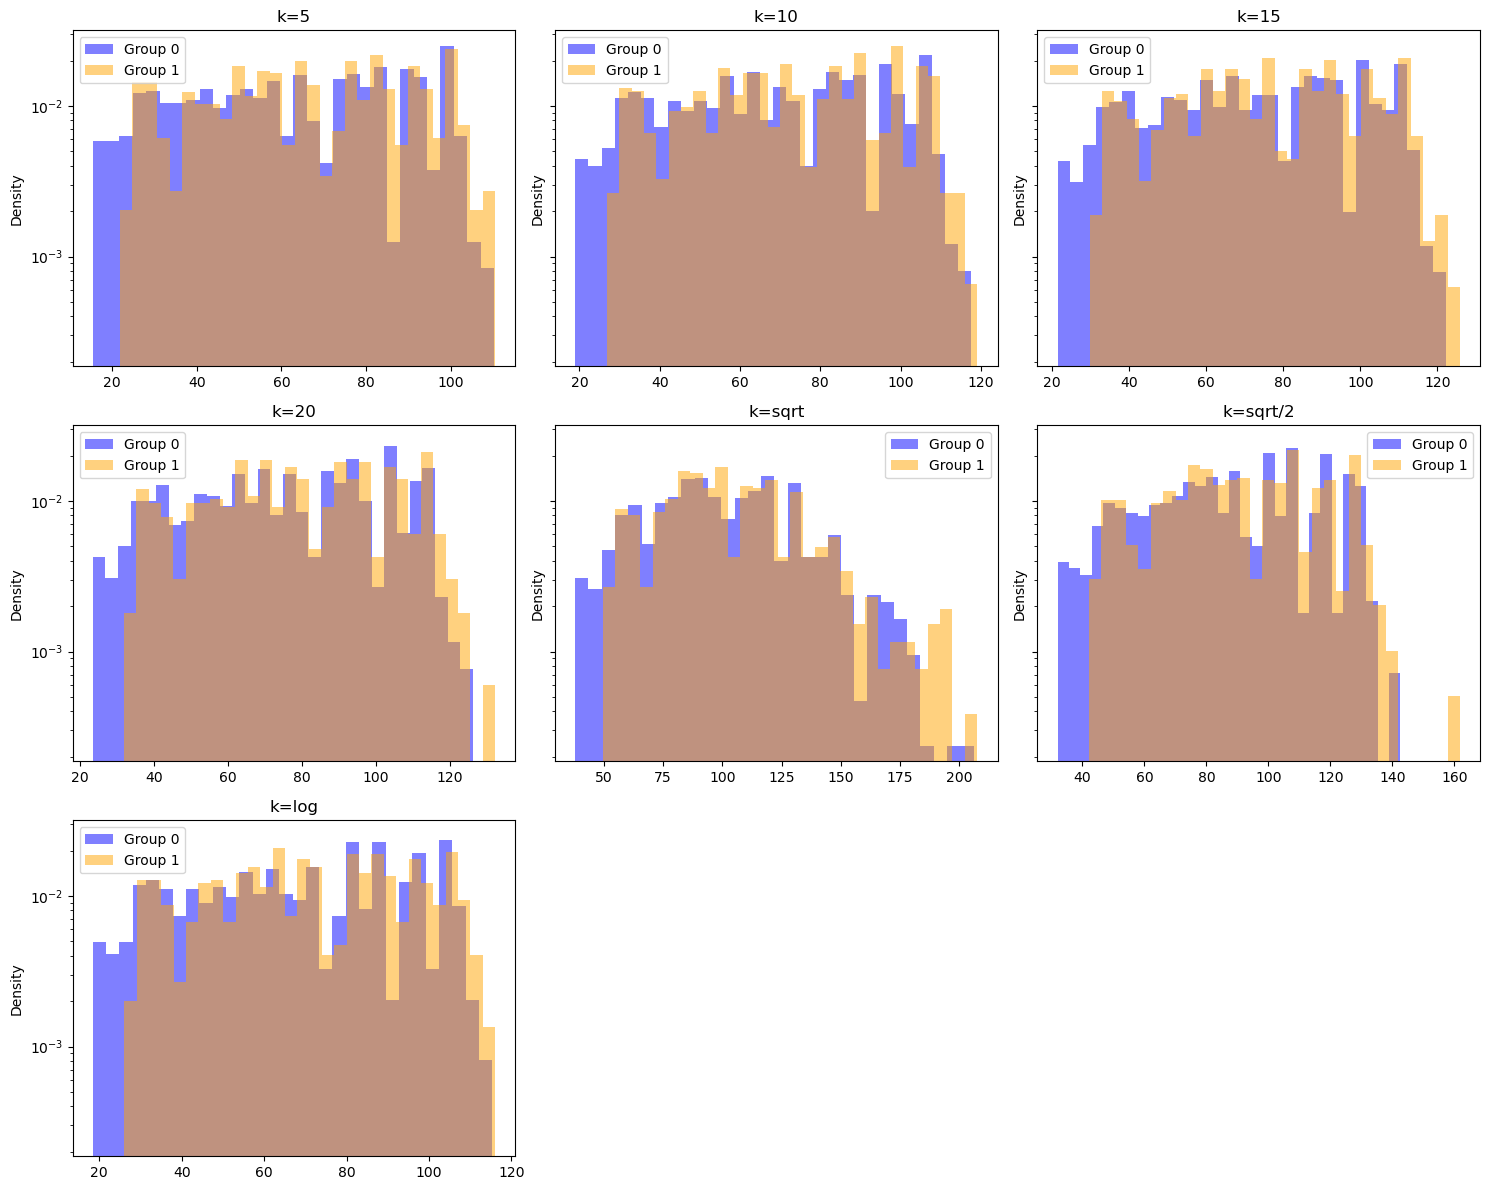

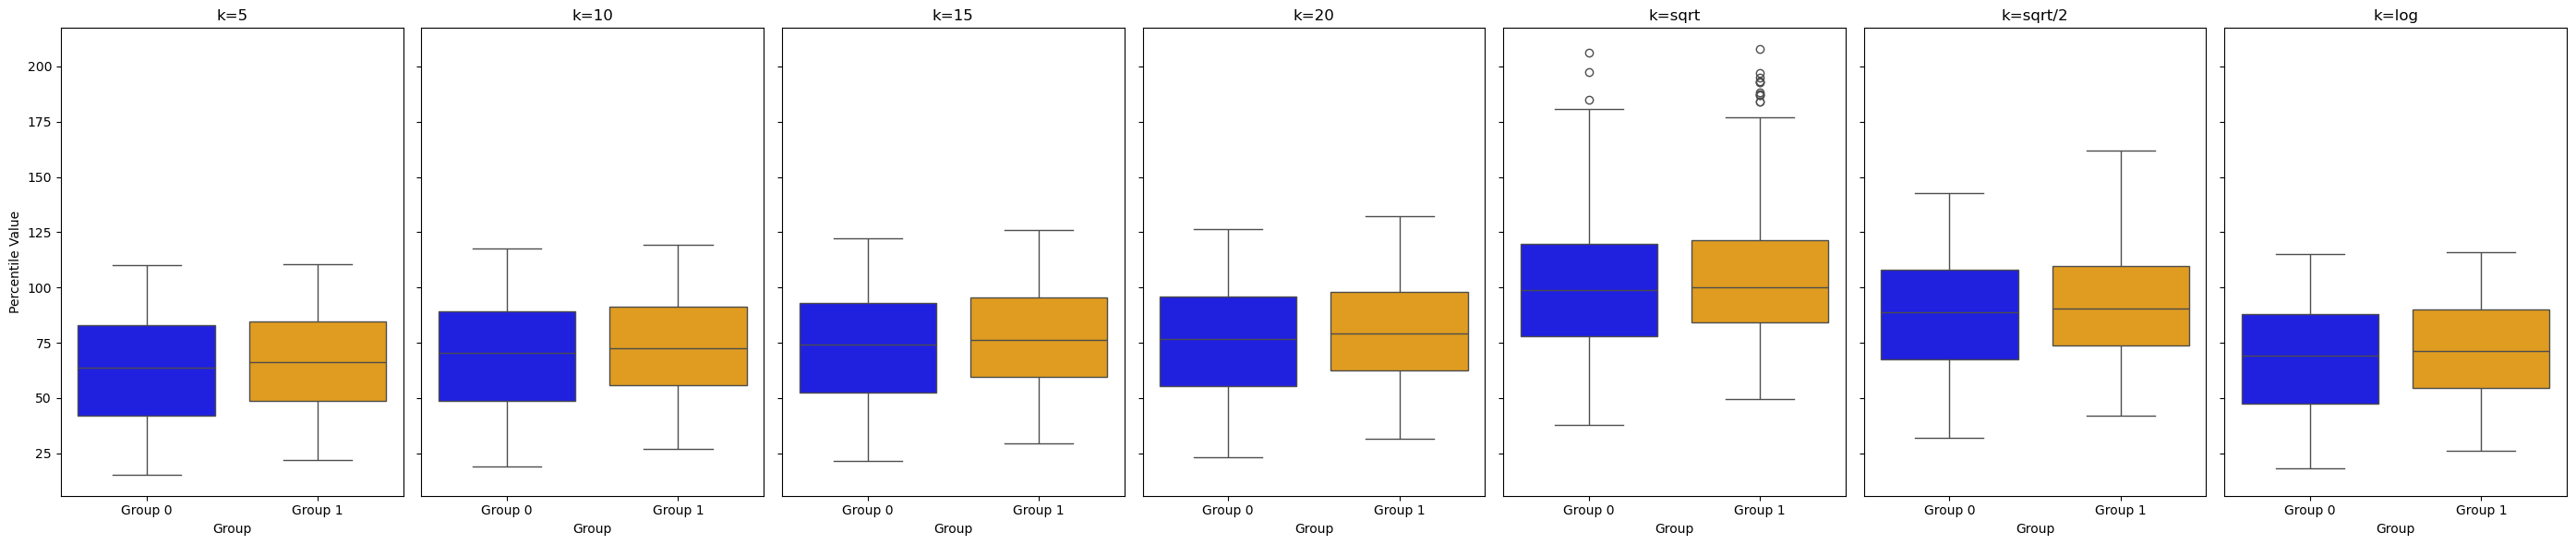

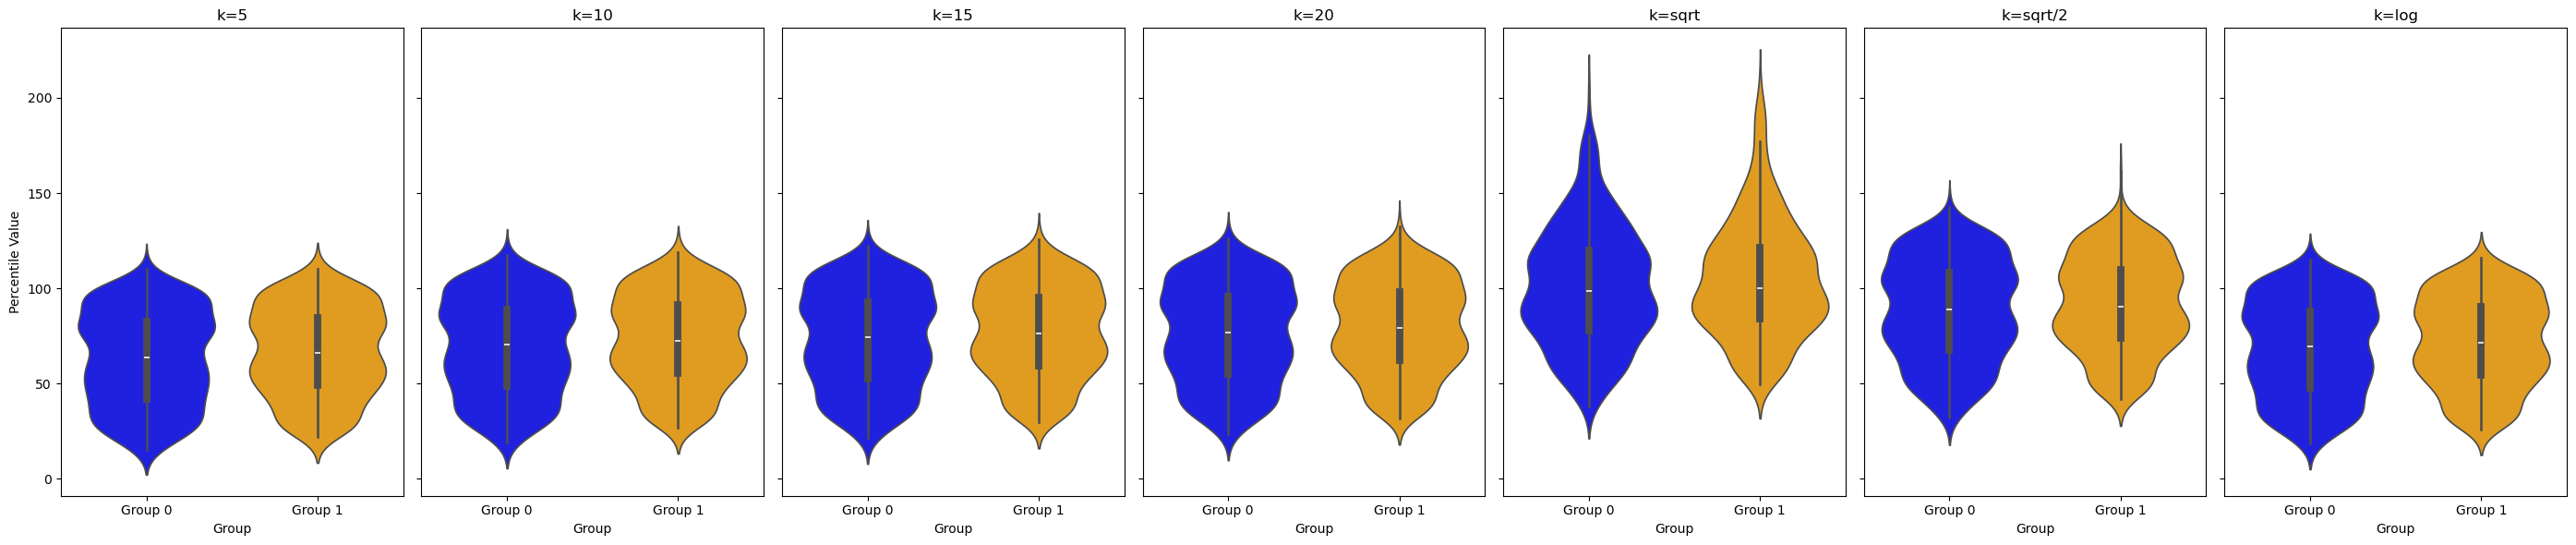

In [40]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_l2_3_all.json")
run_plots(group0, group1, k_values)

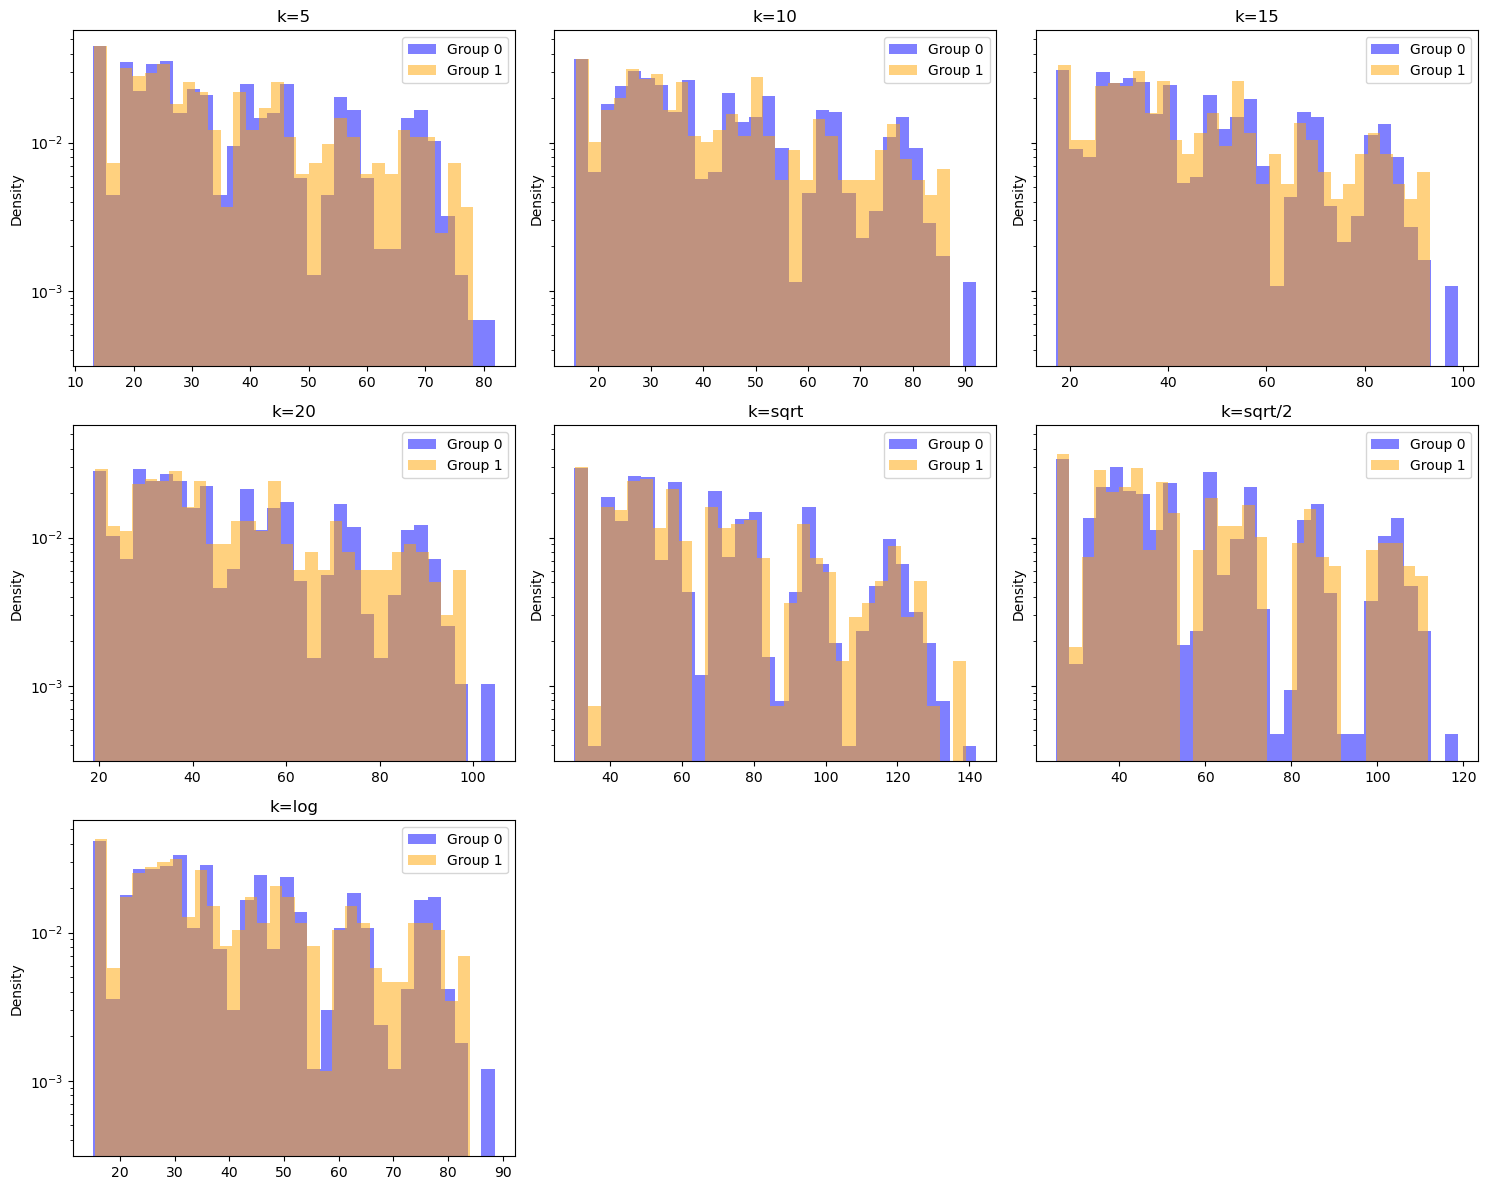

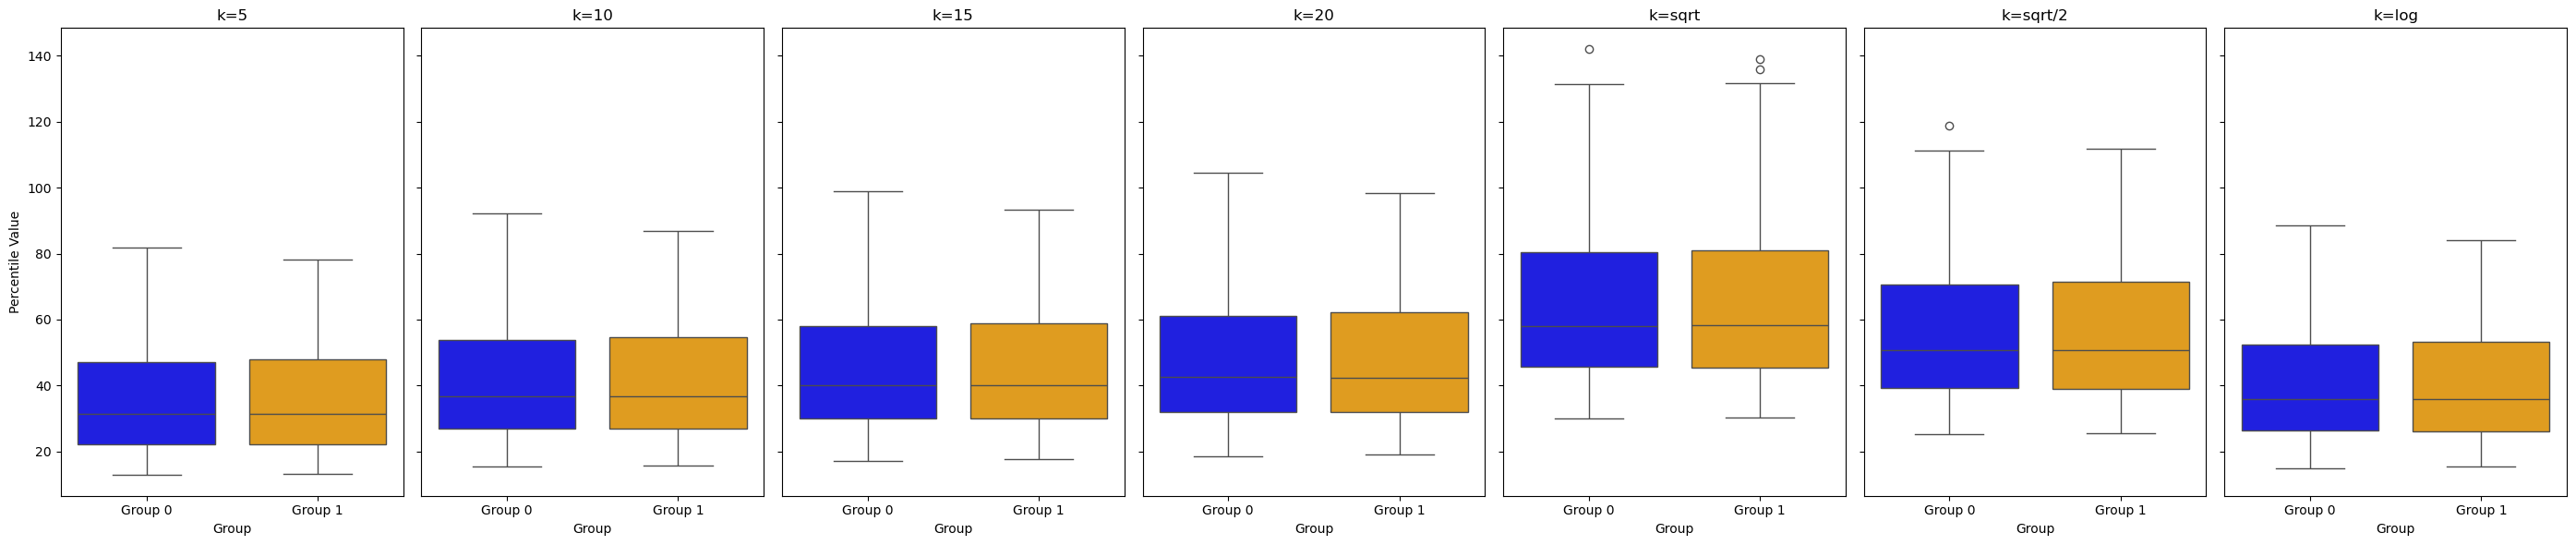

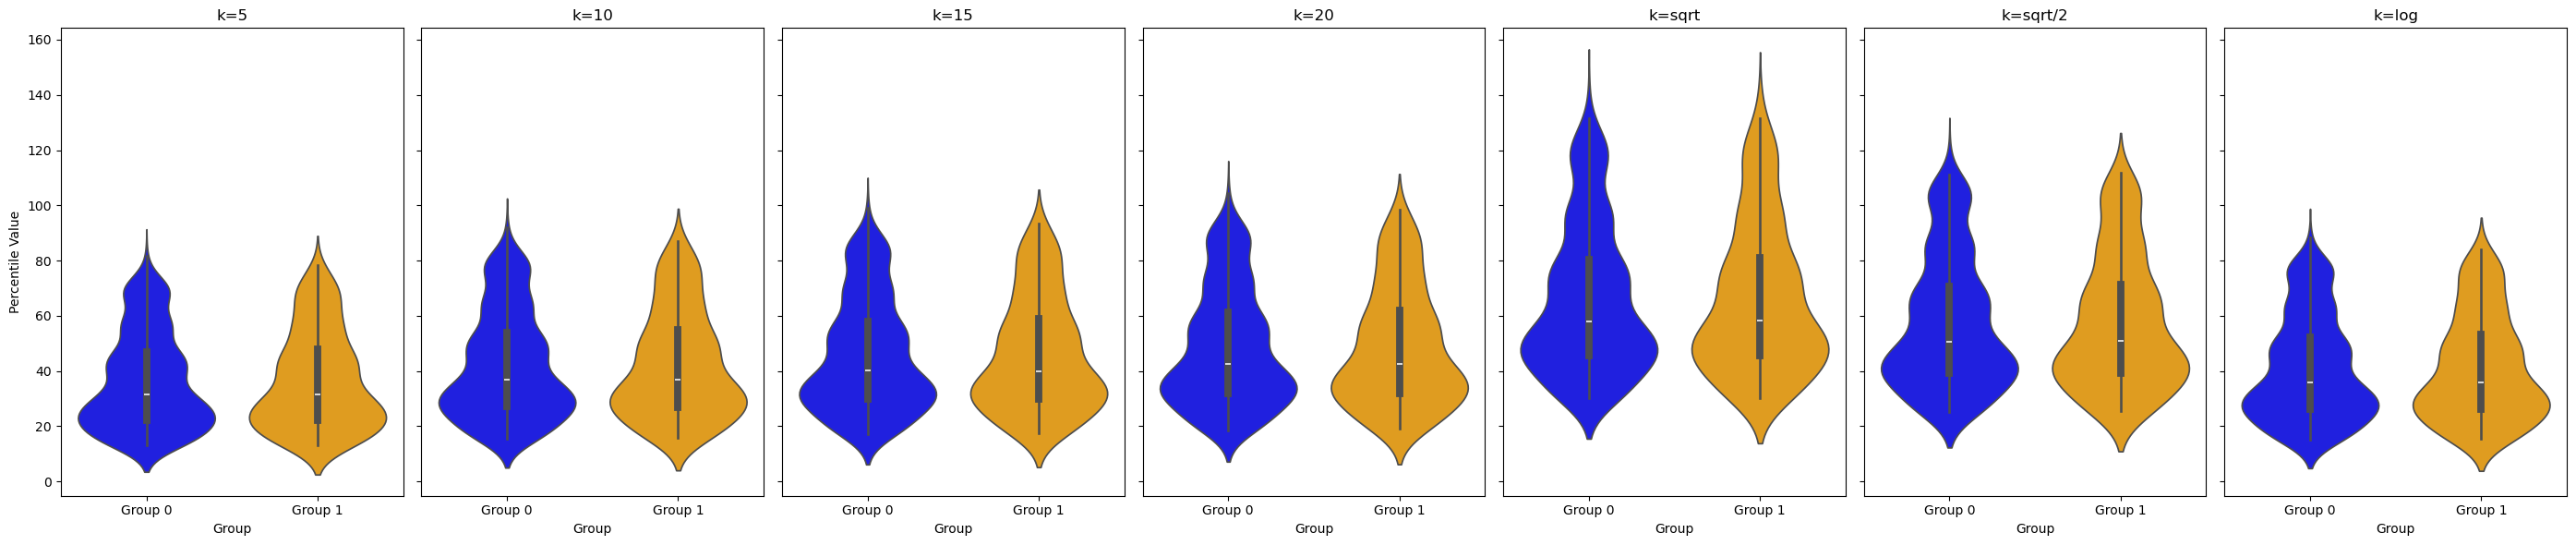

In [41]:
group0,group1 = load_json_groups("/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_l2_3_all_TRA.json")
run_plots(group0, group1, k_values)

## Analyzing Outlines

In [42]:
def load_json_and_extract_features_as_lists(json_path):
    """Load JSON file, extract statistical features, and return structured lists of lists for each group."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    
    for sample_name, percentiles_dict in data.items():
        # Convert the JSON data structure to a list of lists for each sample
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]  # Convert each k-value dictionary entry to a list

        # Extract statistical features for this sample
        features_df = extract_statistical_features_from_percentiles([sample_data], list(percentiles_dict.keys()))

        # Initialize lists for each feature across all k values
        iqr_values = ['iqr']
        lower_tail_range_values = ['lower_tail_range']
        upper_tail_range_values = ['upper_tail_range']
        lower_tail_ratio_values = ['lower_tail_ratio']
        upper_tail_ratio_values = ['upper_tail_ratio']
        percentile_90_10_diff_values = ['percentile_90_10_diff']
        percentile_95_5_diff_values = ['percentile_95_5_diff']
        
        # Populate each feature list with values from all k's in the original JSON order
        for col in features_df.columns[1:]:  # Skip 'Sample' column
            if 'iqr' in col:
                iqr_values.append(features_df[col].iloc[0])
            elif 'lower_tail_range' in col:
                lower_tail_range_values.append(features_df[col].iloc[0])
            elif 'upper_tail_range' in col:
                upper_tail_range_values.append(features_df[col].iloc[0])
            elif 'lower_tail_ratio' in col:
                lower_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'upper_tail_ratio' in col:
                upper_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'percentile_90_10_diff' in col:
                percentile_90_10_diff_values.append(features_df[col].iloc[0])
            elif 'percentile_95_5_diff' in col:
                percentile_95_5_diff_values.append(features_df[col].iloc[0])

        # Combine all feature lists for this sample
        sample_features = [
            iqr_values,
            lower_tail_range_values,
            upper_tail_range_values,
            lower_tail_ratio_values,
            upper_tail_ratio_values,
            percentile_90_10_diff_values,
            percentile_95_5_diff_values,
        ]
        
        # Append to the appropriate group based on sample_name
        if 'H' in sample_name or 'low' in sample_name:
            group_0.append(sample_features)
        elif 'OC' in sample_name or 'high' in sample_name:
            group_1.append(sample_features)
    
    return group_0, group_1

    
def extract_statistical_features_from_percentiles(samples, k_labels):
    """Extract statistical metrics from specified percentiles for each k value in each sample.
    
    Parameters:
    - samples: List of samples, where each sample is a list of lists.
               Each inner list has the format [k_value, p5, p15, p25, p35, p50, p70, p80, p90, p95].
    - k_labels: List of labels for each k value (e.g., [5, 10, 15, 20, 'sqrt', 'sqrt/2', 'log']).
    
    Returns:
    - DataFrame of statistical features for each sample and k value.
    """
    feature_list = []

    for sample_idx, sample in enumerate(samples):
        sample_features = {}
        sample_features['Sample'] = sample_idx
        
        for k_index, k_label in enumerate(k_labels):
            # Extract the provided percentiles for this k value
            percentiles = sample[k_index][1:]  # Exclude the k_value itself, just get percentiles
            
            # Map the percentiles to variables for clarity
            p5, p15, p25, p35, p50, p70, p80, p90, p95 = percentiles

            # Calculate key features
            iqr = p70 - p25  # Interquartile Range (estimated as 75-25 range)
            lower_tail_range = p25 - p5  # Approximate lower tail range as 25-5
            upper_tail_range = p95 - p70  # Approximate upper tail range as 95-75
            
            # Calculate ratios
            lower_tail_ratio = lower_tail_range / iqr if iqr != 0 else 0
            upper_tail_ratio = upper_tail_range / iqr if iqr != 0 else 0
            
            # Additional quantile differences
            percentile_90_10_diff = p90 - p15  # 90th - 10th percentile difference
            percentile_95_5_diff = p95 - p5    # 95th - 5th percentile difference

            # Store features in the dictionary with keys indicating k value and metric
            sample_features[f'k={k_label}_iqr'] = iqr
            sample_features[f'k={k_label}_lower_tail_range'] = lower_tail_range
            sample_features[f'k={k_label}_upper_tail_range'] = upper_tail_range
            sample_features[f'k={k_label}_lower_tail_ratio'] = lower_tail_ratio
            sample_features[f'k={k_label}_upper_tail_ratio'] = upper_tail_ratio
            sample_features[f'k={k_label}_percentile_90_10_diff'] = percentile_90_10_diff
            sample_features[f'k={k_label}_percentile_95_5_diff'] = percentile_95_5_diff
        
        # Add this sample's features to the list
        feature_list.append(sample_features)
    
    # Convert the list of feature dictionaries to a DataFrame
    feature_df = pd.DataFrame(feature_list)
    return feature_df

In [47]:
# Load and extract features for each group
colon_path = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRA/perc_results_cos_3_all_TRA.json"
ovarian_path = '/home/dsi/orrbavly/GNN_project/embeddings/ovarian_percentiles/percentiles_results_cos_3_all.json'

feature_values = ["iqr", "lower_tail_range", "upper_tail_range", "lower_tail_ratio", "upper_tail_ratio", "percentile_90_10_diff", "percentile_95_5_diff"]


In [48]:
samples_group_0_ovarian, samples_group_1_ovarian = load_json_and_extract_features_as_lists(ovarian_path)

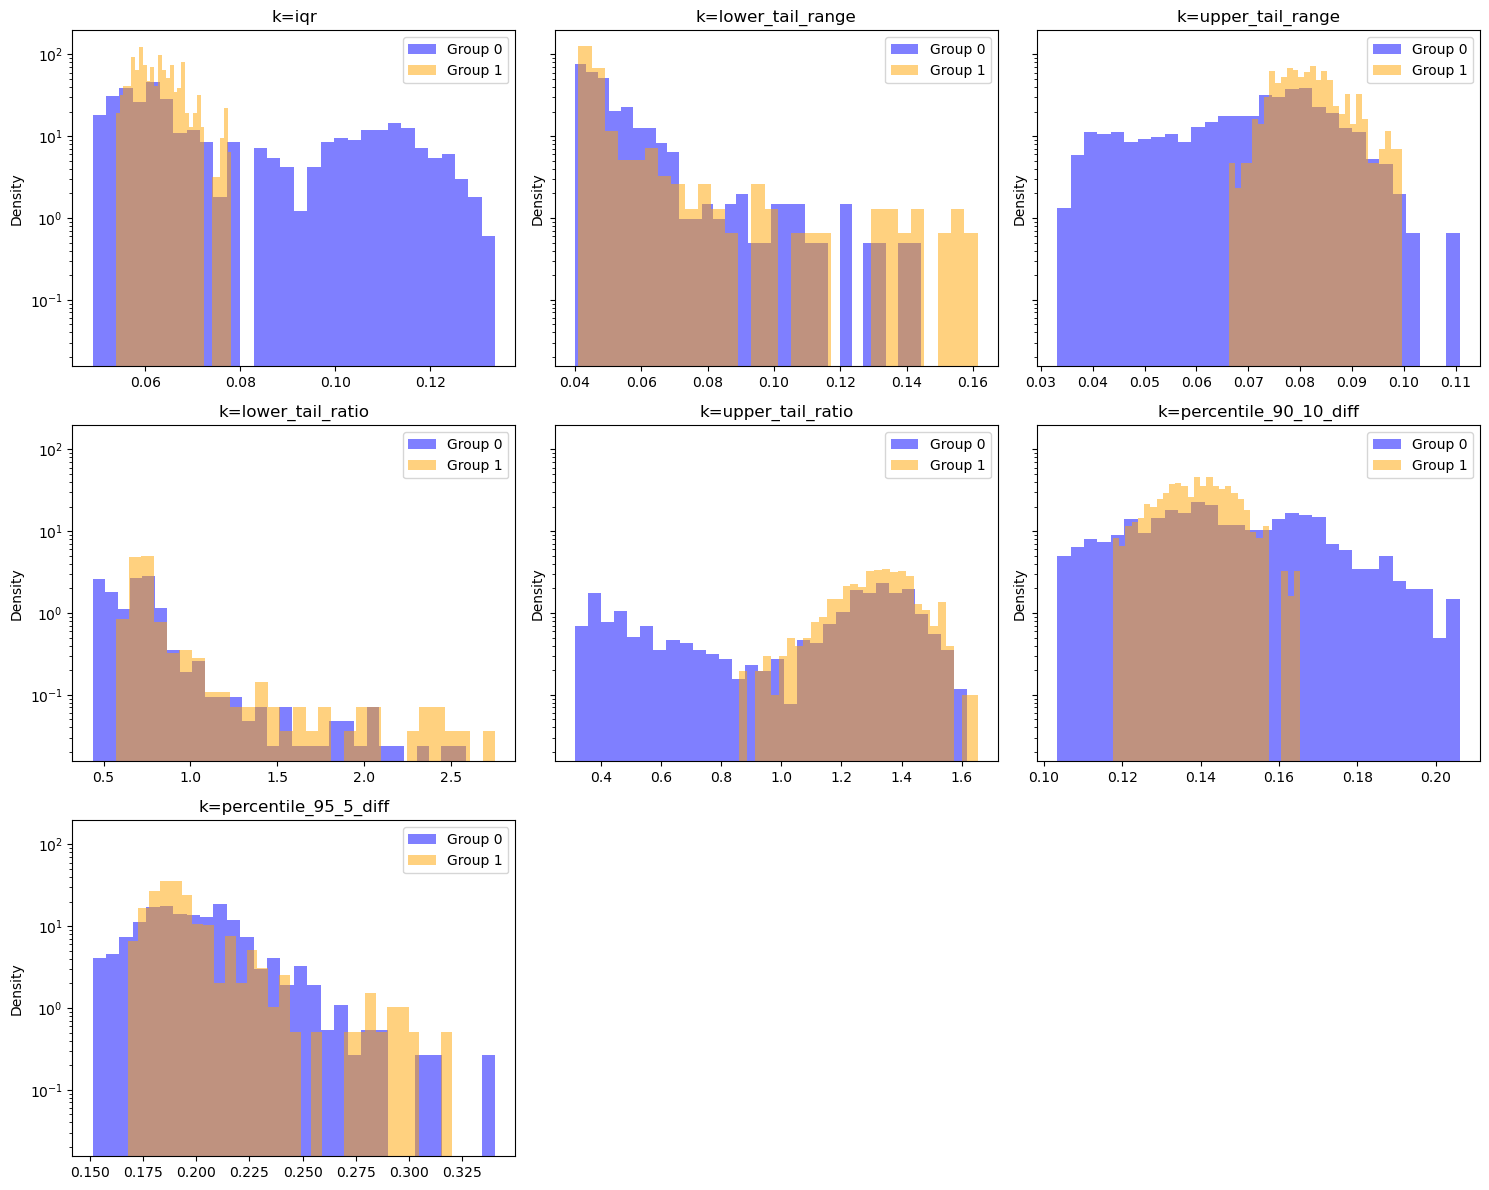

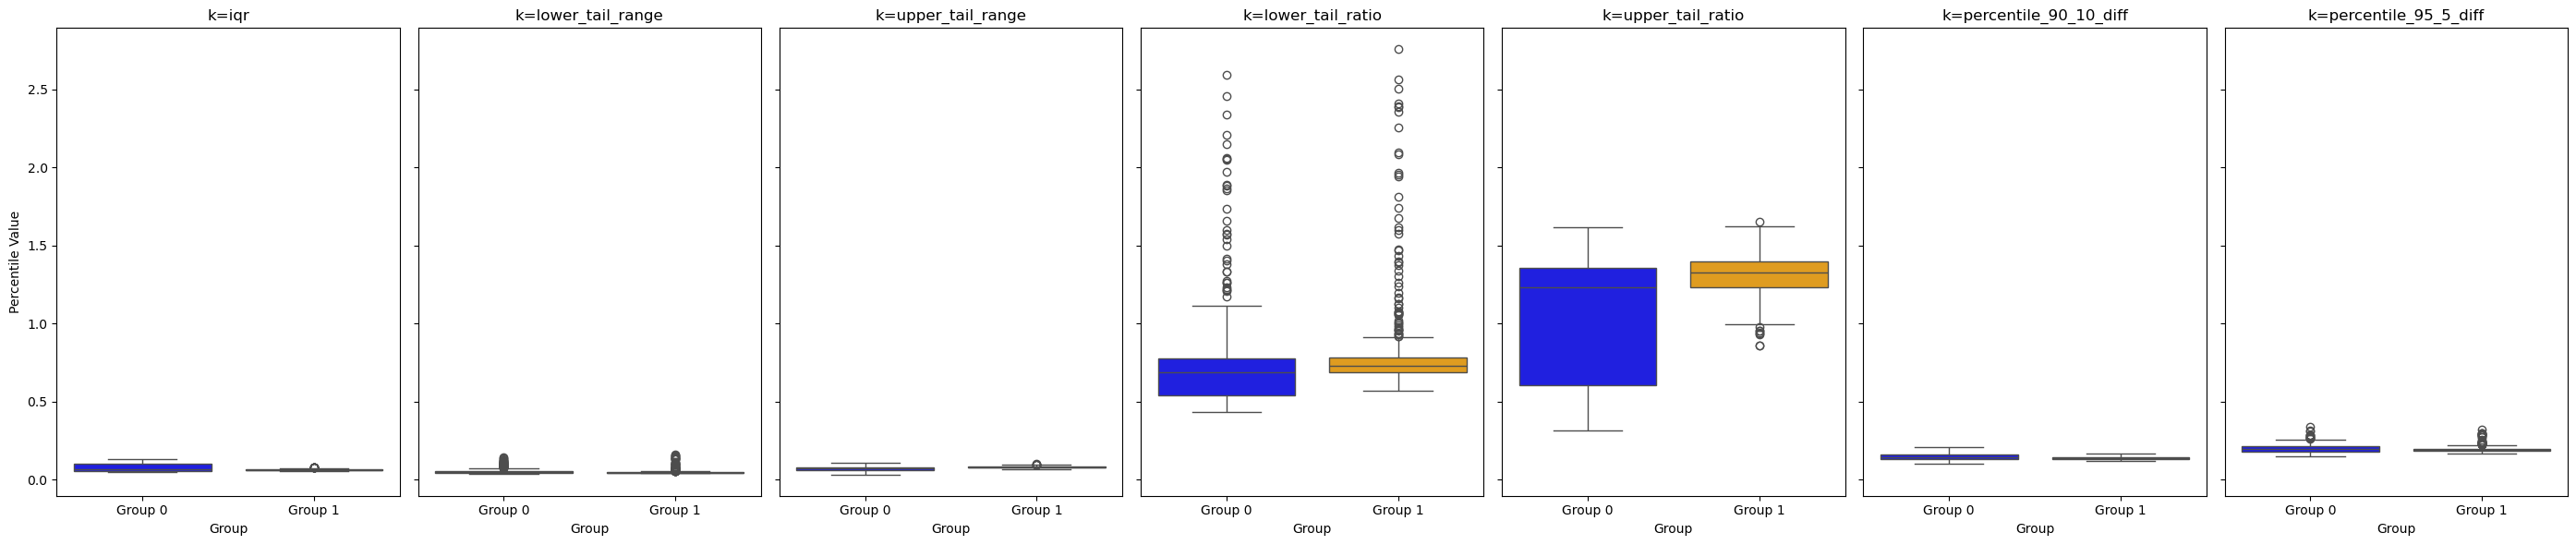

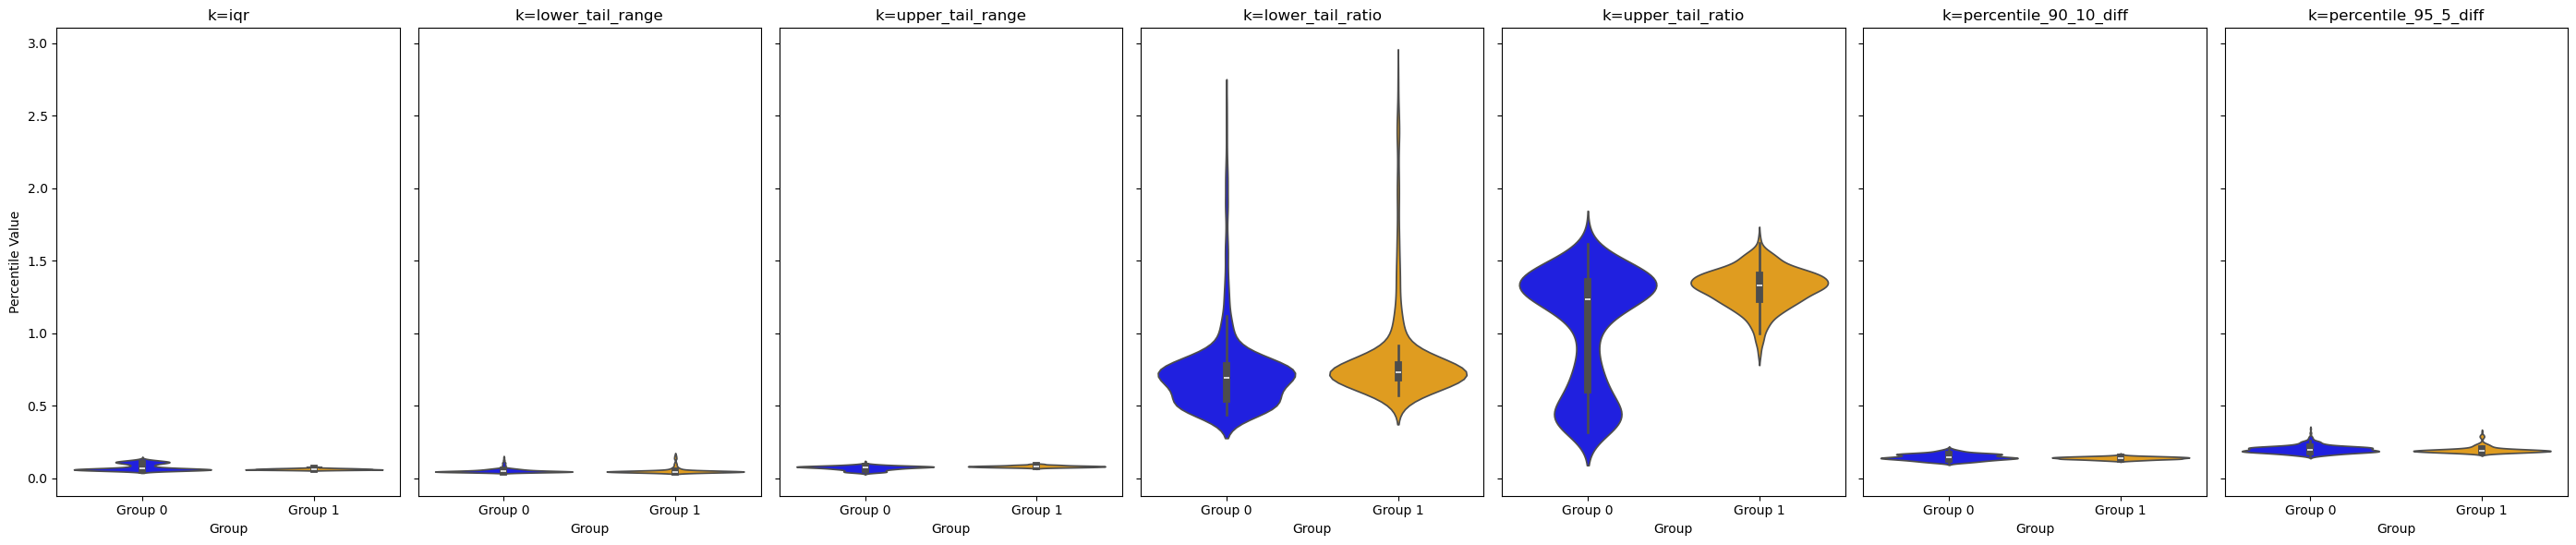

In [49]:
run_plots(samples_group_0_ovarian, samples_group_1_ovarian, feature_values)

In [50]:
samples_group_0_colon, samples_group_1_colon = load_json_and_extract_features_as_lists(colon_path)

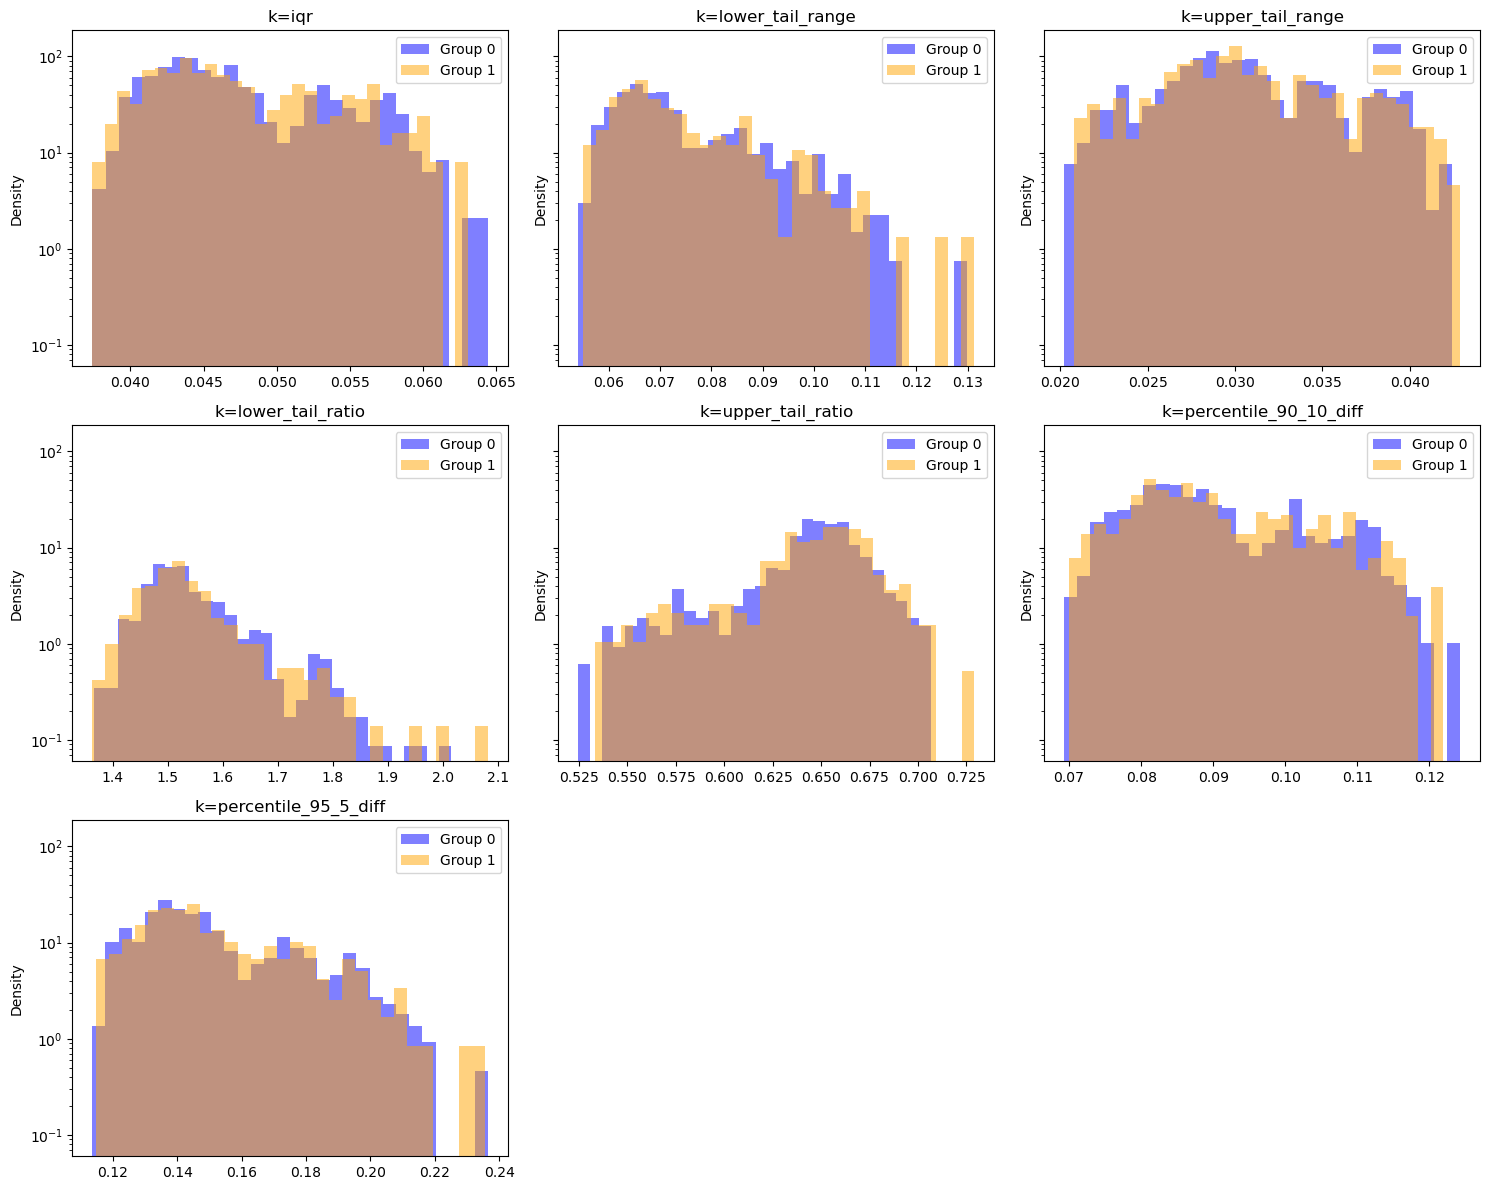

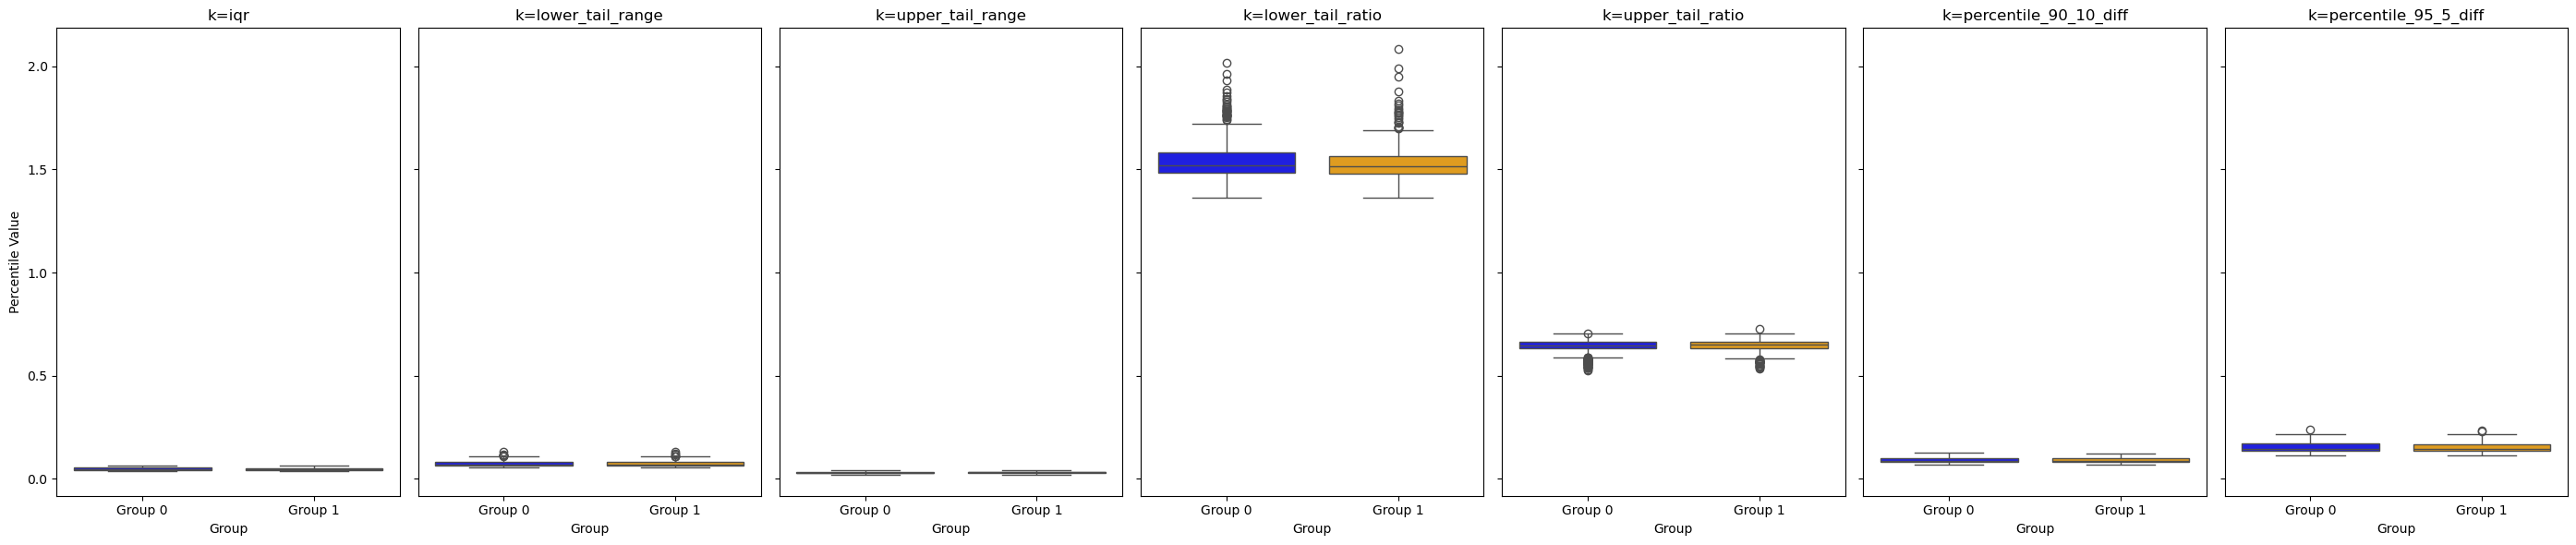

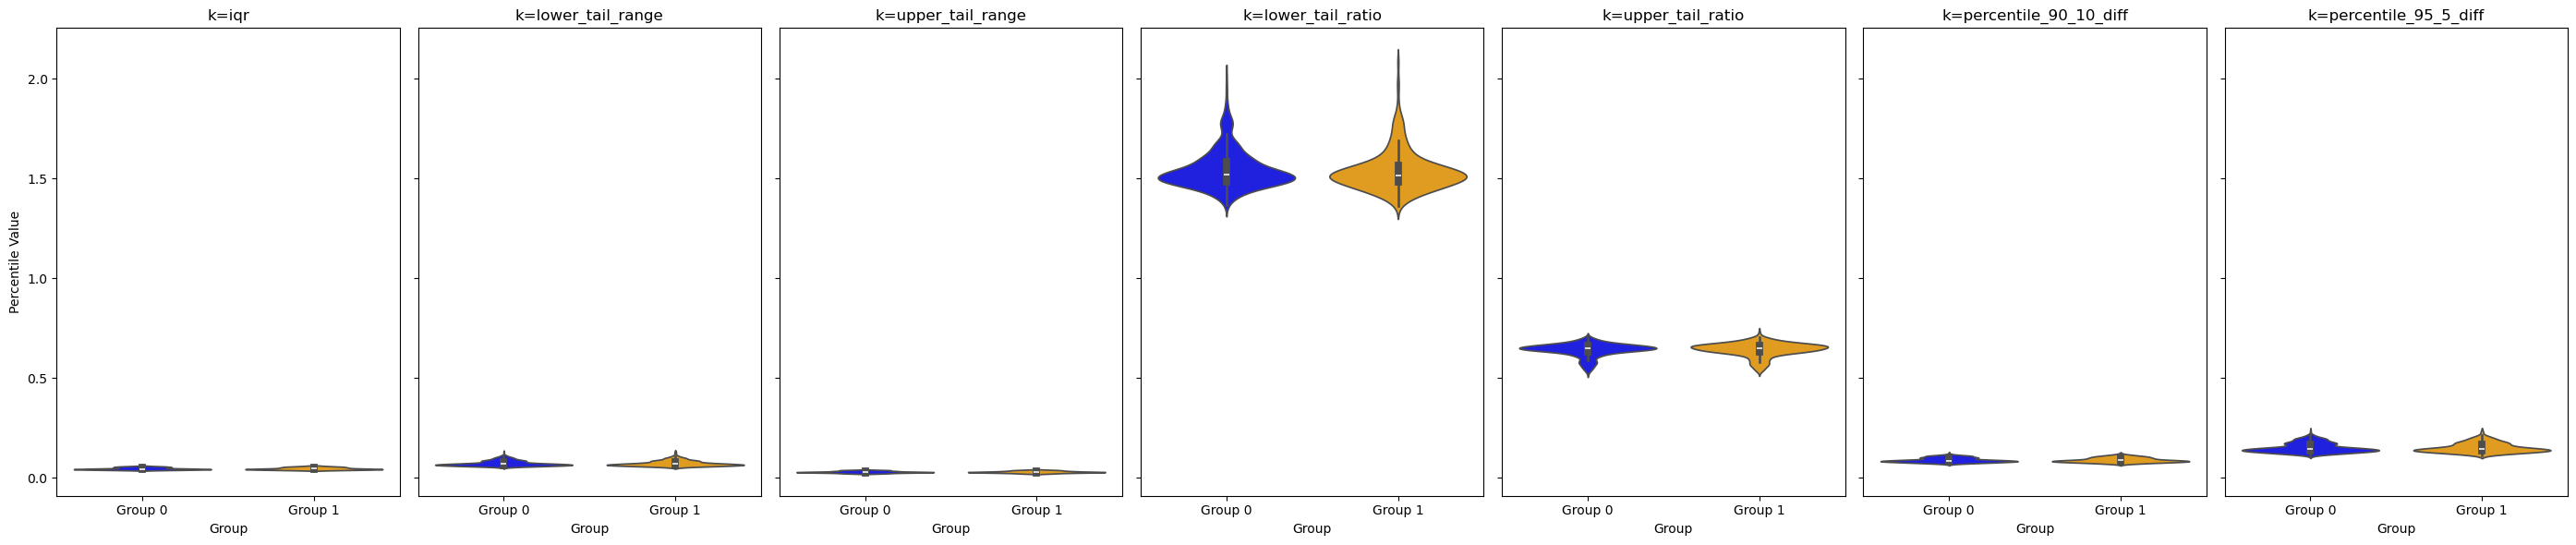

In [51]:
run_plots(samples_group_0_colon, samples_group_1_colon, feature_values)

## ML

In [52]:
def prepare_data_from_groups(group_0, group_1, average_vectors=False, vector_indices=None):
    """
    Prepare data for machine learning algorithms using extracted features from two groups.

    Parameters:
    - group_0: List of lists for Group 0, where each inner list represents a patient.
    - group_1: List of lists for Group 1, where each inner list represents a patient.
    - average_vectors: If True, averages the vectors across k values instead of concatenating.
    - vector_indices: Optional list of indices specifying which features to include.

    Returns:
    - X_train, X_test, y_train, y_test: Prepared training and testing data and labels.
    """
    data = []
    labels = []

    # Define the maximum length for padding
    max_length = 0

    # Combine groups and assign labels
    combined_data = group_0 + group_1
    combined_labels = [0] * len(group_0) + [1] * len(group_1)

    # Find the maximum length needed for padding based on selected indices
    if not average_vectors:
        if vector_indices is not None:
            # Calculate max length based only on selected features
            max_length = max(len(np.concatenate([patient_features[i][1:] for i in vector_indices if i < len(patient_features)]))
                            for patient_features in combined_data)
        else:
            # Calculate max length based on all features if no indices are specified
            max_length = max(len(np.concatenate([feature[1:] for feature in patient_features])) 
                            for patient_features in combined_data)

    for patient_features, label in zip(combined_data, combined_labels):
        # Extract values for each feature (ignore the feature names)
        vectors = [feature[1:] for feature in patient_features]
        
        if average_vectors:
            # Calculate the mean across all k values for each feature
            avg_vector = np.mean(np.array(vectors), axis=0)
            data.append(avg_vector)
        else:
            # Select specific feature indices if provided
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_features = np.concatenate(selected_vectors)
            else:
                flattened_features = np.concatenate(vectors)
            
            # Pad the concatenated features to match the max length of selected features
            padded_features = np.pad(flattened_features, (0, max_length - len(flattened_features)), 'constant')
            data.append(padded_features)

            # Append the label
            labels.append(label)

    # Convert data and labels to arrays
    data = np.array(data)
    labels = np.array(labels)

    # # Separate indices for each label
    # indices_label_0 = np.where(labels == 0)[0]
    # indices_label_1 = np.where(labels == 1)[0]

    # # Randomly select 49 samples from label 0
    # np.random.seed(42)  # Set seed for reproducibility
    # selected_indices_label_0 = np.random.choice(indices_label_0, 49, replace=False)

    # # Combine selected indices from both labels
    # balanced_indices = np.concatenate([selected_indices_label_0, indices_label_1])

    # # Create balanced data and labels based on the selected indices
    # data_balanced = data[balanced_indices]
    # labels_balanced = labels[balanced_indices]

    # # Split balanced data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(data_balanced, labels_balanced, test_size=0.2, stratify=labels_balanced, random_state=42)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

    # Standardize the feature values
    scaler = sklearn.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # # Verify the balance in the training set - REMOVE LATER
    # print("Training set label distribution:", np.bincount(y_train))
    # print("Test set label distribution:", np.bincount(y_test))

    return X_train, X_test, y_train, y_test

In [53]:
# Generate descriptive feature names
feature_names = [f"{feature}_{k}" for feature in feature_values for k in k_values]

In [87]:
X_train_col, X_test_col, y_train_col, y_test_col = prepare_data_from_groups(samples_group_0_colon, samples_group_1_colon)

In [88]:
print(y_train_col, len(y_train_col))
print(y_test_col, len(y_test_col))

[1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1] 94
[0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0] 24


In [56]:
results_col = []
models_col = []

In [57]:
run_evaluation(X_train_col, X_test_col, y_train_col, y_test_col, k_value="all_k", results=results_col, models=models_col)

KNN Results
Accuracy: 0.6666666666666666
Confusion Matrix:
[[13  2]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.60      0.33      0.43         9

    accuracy                           0.67        24
   macro avg       0.64      0.60      0.60        24
weighted avg       0.65      0.67      0.64        24

ROC-AUC: 0.6888888888888889
Logistic Regression Results
Accuracy: 0.7083333333333334
Confusion Matrix:
[[14  1]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.75      0.33      0.46         9

    accuracy                           0.71        24
   macro avg       0.72      0.63      0.63        24
weighted avg       0.72      0.71      0.67        24

ROC-AUC: 0.5629629629629629
SVM Results
Accuracy: 0.625
Confusion Matrix:
[[14  1]
 [ 8  1]]
Classif

Random Forest Results
Accuracy: 0.5833333333333334
Confusion Matrix:
[[13  2]
 [ 8  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72        15
           1       0.33      0.11      0.17         9

    accuracy                           0.58        24
   macro avg       0.48      0.49      0.44        24
weighted avg       0.51      0.58      0.51        24

ROC-AUC: 0.6037037037037036


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Results
Accuracy: 0.5
Confusion Matrix:
[[8 7]
 [5 4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.36      0.44      0.40         9

    accuracy                           0.50        24
   macro avg       0.49      0.49      0.49        24
weighted avg       0.52      0.50      0.51        24

ROC-AUC: 0.45185185185185184
XGBoost Results:
Accuracy: 0.7916666666666666
Confusion Matrix:
[[14  1]
 [ 4  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.83      0.56      0.67         9

    accuracy                           0.79        24
   macro avg       0.81      0.74      0.76        24
weighted avg       0.80      0.79      0.78        24

ROC-AUC: 0.7037037037037036


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-12 12:03:26.073352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78515 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-11-12 12:03:26.075039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
I0000 00:00:1731405808.115552 2970099 service.cc:146] XLA service 0x7f9d70005b00 initialized for platform CUDA (this does

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural Network Results:
Accuracy: 0.6666666666666666
Confusion Matrix:
[[12  3]
 [ 5  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.57      0.44      0.50         9

    accuracy                           0.67        24
   macro avg       0.64      0.62      0.62        24
weighted avg       0.66      0.67      0.66        24

ROC-AUC: 0.45185185185185184


In [58]:
train_and_evaluate_nn(X_train_col, X_test_col, y_train_col, y_test_col)

/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Neural Network Results:
Accuracy: 0.5833333333333334
Confusion Matrix:
[[13  2]
 [ 8  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72        15
           1       0.33      0.11      0.17         9

    accuracy                           0.58        24
   macro avg       0.48      0.49      0.44        24
weighted avg       0.51      0.58      0.51        24

ROC-AUC: 0.3333333333333333


(<Sequential name=sequential_1, built=True>,
 {'model': 'Neural Network',
  'accuracy': 0.5833333333333334,
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.62      0.87      0.72        15\n           1       0.33      0.11      0.17         9\n\n    accuracy                           0.58        24\n   macro avg       0.48      0.49      0.44        24\nweighted avg       0.51      0.58      0.51        24\n'})

In [59]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test_xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(90 / 49))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("XGBoost Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

test_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

XGBoost Results:
Accuracy: 0.625
Confusion Matrix:
[[11  4]
 [ 5  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.50      0.44      0.47         9

    accuracy                           0.62        24
   macro avg       0.59      0.59      0.59        24
weighted avg       0.62      0.62      0.62        24

ROC-AUC: 0.7259259259259259


In [60]:
train_grid_svm(X_train_col, X_test_col, y_train_col, y_test_col)
# train_grid_rf(X_train_col, X_test_col, y_train_col, y_test_col)
train_grid_mlp(X_train_col, X_test_col, y_train_col, y_test_col)

Best Parameters: {'svm__C': 0.1, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
Best Score: 0.660233918128655
Test Accuracy: 0.625
[[15  0]
 [ 9  0]]


/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dsi/orrbavly/miniconda3/envs/dl/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converge

Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'sgd'}
Best Score: 0.6064327485380117
Test Accuracy: 0.6666666666666666
[[13  2]
 [ 6  3]]


### Feature selection

In [61]:
# Map each feature name to its full feature type explicitly
def extract_feature_type(feature_name):
    for feature_type in ['iqr', 'lower_tail_range', 'upper_tail_range', 'lower_tail_ratio', 
                 'upper_tail_ratio', 'percentile_90_10_diff', 'percentile_95_5_diff']:
        if feature_name.startswith(feature_type):
            return feature_type
    return "Unknown"  # In case a feature doesn't match (for debugging)

def test_rf(X_train, X_test, y_train, y_test, feature_names):
    random_forest = RandomForestClassifier(class_weight='balanced', random_state=42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print("Random Forest Results:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)

    # Feature importance
    feature_importances = random_forest.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(importance_df)

    # Use the full feature type for aggregation
    importance_df['Feature_Type'] = importance_df['Feature'].apply(extract_feature_type)
    aggregated_importance = importance_df.groupby('Feature_Type')['Importance'].sum().sort_values(ascending=False)
    
    print("\nAggregated Feature Importances by Feature Type:")
    print(aggregated_importance)

    # return top N features
    N = 5
    top_features = aggregated_importance.head(N).index.tolist()
    return top_features


top_featurs_colon = test_rf(X_train_col, X_test_col, y_train_col, y_test_col, feature_names)

Random Forest Results:
Accuracy: 0.625
Confusion Matrix:
[[14  1]
 [ 8  1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76        15
           1       0.50      0.11      0.18         9

    accuracy                           0.62        24
   macro avg       0.57      0.52      0.47        24
weighted avg       0.59      0.62      0.54        24


Feature Importances:
                         Feature  Importance
28            upper_tail_ratio_5    0.029947
13          lower_tail_range_log    0.029527
26       lower_tail_ratio_sqrt/2    0.029463
42        percentile_95_5_diff_5    0.029444
22           lower_tail_ratio_10    0.027979
0                          iqr_5    0.027348
1                         iqr_10    0.026793
25         lower_tail_ratio_sqrt    0.026778
30           upper_tail_ratio_15    0.025896
40  percentile_90_10_diff_sqrt/2    0.025589
33       upper_tail_ratio_sqrt/2    0.025273
27          

In [62]:
top_feat_col_indices = [feature_values.index(feature) for feature in top_featurs_colon]


In [63]:
X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3 = prepare_data_from_groups(samples_group_0_colon, samples_group_1_colon, vector_indices=top_feat_col_indices)

In [64]:
print(y_train_col_3, len(y_train_col_3))
print(y_test_col_3, len(y_test_col_3))

[0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0] 94
[0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0] 24


In [65]:
run_evaluation(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3, k_value="all_k", results=[], models=[])

KNN Results
Accuracy: 0.7916666666666666
Confusion Matrix:
[[15  0]
 [ 5  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.44      0.62         9

    accuracy                           0.79        24
   macro avg       0.88      0.72      0.74        24
weighted avg       0.84      0.79      0.77        24

ROC-AUC: 0.6888888888888889
Logistic Regression Results
Accuracy: 0.75
Confusion Matrix:
[[15  0]
 [ 6  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        15
           1       1.00      0.33      0.50         9

    accuracy                           0.75        24
   macro avg       0.86      0.67      0.67        24
weighted avg       0.82      0.75      0.71        24

ROC-AUC: 0.5703703703703703
SVM Results
Accuracy: 0.6666666666666666
Confusion Matrix:
[[14  1]
 [ 7  2]]
Classifi

Random Forest Results
Accuracy: 0.7916666666666666
Confusion Matrix:
[[14  1]
 [ 4  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.83      0.56      0.67         9

    accuracy                           0.79        24
   macro avg       0.81      0.74      0.76        24
weighted avg       0.80      0.79      0.78        24

ROC-AUC: 0.6777777777777778
MLP Results
Accuracy: 0.5
Confusion Matrix:
[[8 7]
 [5 4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.36      0.44      0.40         9

    accuracy                           0.50        24
   macro avg       0.49      0.49      0.49        24
weighted avg       0.52      0.50      0.51        24

ROC-AUC: 0.5555555555555556
XGBoost Results:
Accuracy: 0.6666666666666666
Confusion Matrix:
[[10  5]
 [ 3  6]]
Classification

In [82]:
train_grid_xgboost(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.2, 'subsample': 0.7}
Best Recall Score from Grid Search: nan

XGBoost Results with Best Parameters for Label 1 Recall:
Accuracy: 0.625
Confusion Matrix:
[[15  0]
 [ 9  0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        15
           1       0.00      0.00      0.00         9

    accuracy                           0.62        24
   macro avg       0.31      0.50      0.38        24
weighted avg       0.39      0.62      0.48        24

ROC-AUC: 0.6444444444444444


In [92]:
train_grid_xgboost(X_train_col, X_test_col, y_train_col, y_test_col)

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1.5, 'subsample': 0.7}
Best Recall Score from Grid Search: nan

XGBoost Results with Best Parameters for Label 1 Recall:
Accuracy: 0.6666666666666666
Confusion Matrix:
[[14  1]
 [ 7  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.67      0.22      0.33         9

    accuracy                           0.67        24
   macro avg       0.67      0.58      0.56        24
weighted avg       0.67      0.67      0.61        24

ROC-AUC: 0.6


### GO

In [96]:
train_grid_rf(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

Best Parameters: {'rf__bootstrap': True, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 15, 'rf__n_estimators': 50}
Best ROC-AUC Score from Grid Search: 0.5363581367211131

Random Forest Results with Best Parameters:
Accuracy: 0.6666666666666666
Confusion Matrix:
[[10  5]
 [ 3  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.55      0.67      0.60         9

    accuracy                           0.67        24
   macro avg       0.66      0.67      0.66        24
weighted avg       0.69      0.67      0.67        24

ROC-AUC: 0.5925925925925926


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def test(X_train, X_test, y_train, y_test):
    # Define the Random Forest model with the specified parameters
    rf_model = RandomForestClassifier(
        bootstrap=False,
        max_depth=15,
        max_features='log2',
        min_samples_leaf=2,
        min_samples_split=5,
        n_estimators=200,
        class_weight='balanced'  # Optional: Add class weighting if you have class imbalance
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print evaluation metrics
    print("Random Forest Results with Specified Parameters:")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"ROC-AUC: {roc_auc}")

test(X_train_col_3, X_test_col_3, y_train_col_3, y_test_col_3)

Random Forest Results with Specified Parameters:
Accuracy: 0.625
Confusion Matrix:
[[10  5]
 [ 4  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.50      0.56      0.53         9

    accuracy                           0.62        24
   macro avg       0.61      0.61      0.61        24
weighted avg       0.63      0.62      0.63        24

ROC-AUC: 0.674074074074074


OVARIAN

In [69]:
X_train_ov, X_test_ov, y_train_ov, y_test_ov = prepare_data_from_groups(samples_group_0_ovarian, samples_group_1_ovarian)

In [70]:
results_ov = []
models_ov = []

In [71]:
run_evaluation(X_train_ov, X_test_ov, y_train_ov, y_test_ov, k_value="all_k", results=results_ov, models=models_ov)

KNN Results
Accuracy: 0.6428571428571429
Confusion Matrix:
[[14  3]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.57      0.36      0.44        11

    accuracy                           0.64        28
   macro avg       0.62      0.59      0.59        28
weighted avg       0.63      0.64      0.62        28

ROC-AUC: 0.7914438502673797
Logistic Regression Results
Accuracy: 0.6785714285714286
Confusion Matrix:
[[14  3]
 [ 6  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76        17
           1       0.62      0.45      0.53        11

    accuracy                           0.68        28
   macro avg       0.66      0.64      0.64        28
weighted avg       0.67      0.68      0.67        28

ROC-AUC: 0.7807486631016043
SVM Results
Accuracy: 0.7142857142857143
Confusion Matrix:
[[14  3]
 [ 5